In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-densenet121-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet121(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 154s 17ms/step - loss: 0.8028 - acc: 0.7771 - val_loss: 10.0325 - val_acc: 0.1240
Epoch 2/100
9112/9112 [==============================] - 113s 12ms/step - loss: 0.3807 - acc: 0.8919 - val_loss: 7.2545 - val_acc: 0.3125
Epoch 3/100
9112/9112 [==============================] - 114s 12ms/step - loss: 0.2916 - acc: 0.9140 - val_loss: 5.6116 - val_acc: 0.4033
Epoch 4/100
9112/9112 [==============================] - 112s 12ms/step - loss: 0.2217 - acc: 0.9354 - val_loss: 3.3186 - val_acc: 0.4785
Epoch 5/100
9112/9112 [==============================] - 113s 12ms/step - loss: 0.2009 - acc: 0.9425 - val_loss: 1.2811 - val_acc: 0.7041
Epoch 6/100
9112/9112 [==============================] - 113s 12ms/step - loss: 0.1608 - acc: 0.9525 - val_loss: 0.5597 - val_acc: 0.8447
Epoch 7/100
9112/9112 [==============================] - 111s 12ms/step - loss: 0.1467 - acc: 0.9570 - val_loss: 1.0957 - v

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9614


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

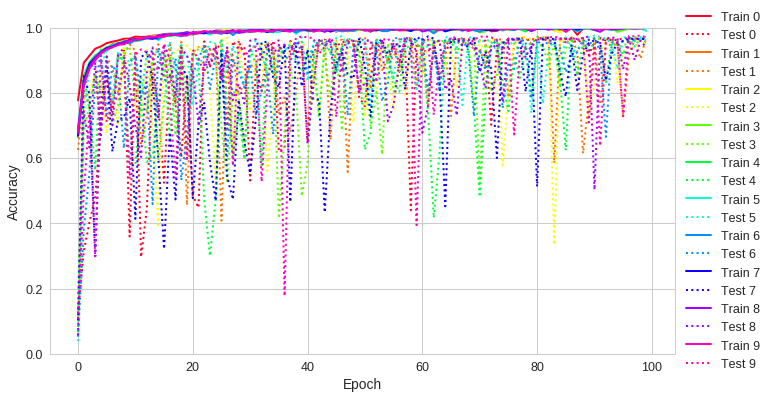

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

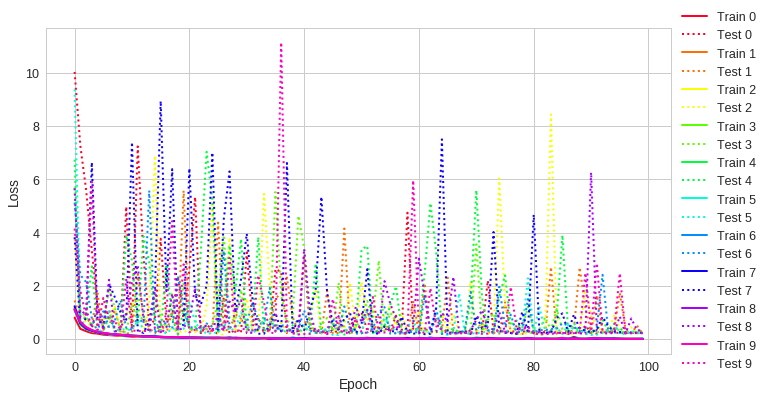

In [25]:
plot_loss(history)

Plotting the confusion matrix


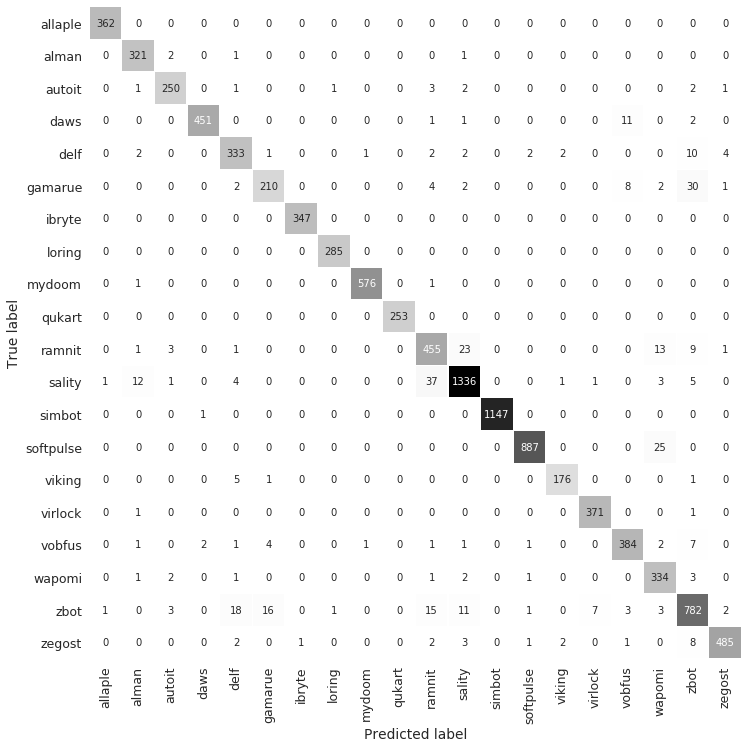

In [26]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


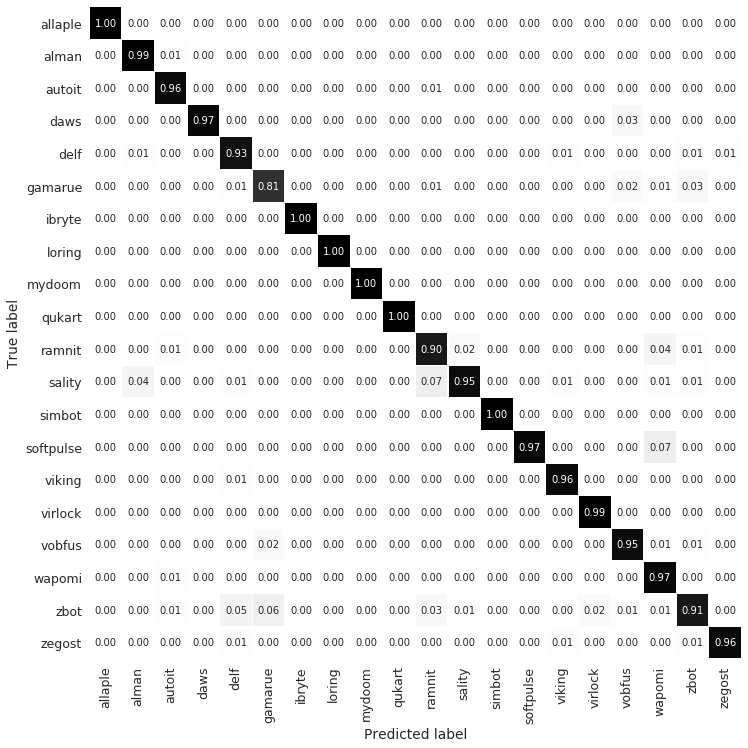

In [27]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
for h in history:
    print(h.history)

{'val_loss': [10.032479166984558, 7.25446912040934, 5.611573495960329, 3.318602446670411, 1.2810774010722525, 0.5596845358891613, 1.0956541214836761, 0.3077448972617276, 0.24326672608458466, 4.969384912550595, 0.3869512124419998, 7.23451826730161, 3.1214877613820136, 0.5079890467459336, 0.7209909317566598, 3.7684886579445447, 0.6446662180302951, 0.8911112088535447, 2.3375591267758864, 0.6871061030687997, 2.6339269139207317, 5.333094822628482, 0.18474083056764812, 0.5632592836077492, 0.304136994713069, 0.1945284377253529, 1.5762475336669013, 0.20762663843661144, 0.34901931607006986, 0.24838463171076341, 3.2495857675676234, 0.6744134222608409, 0.7514679766100016, 0.3957961283579152, 0.2563606073117626, 2.6288795823127202, 2.5180774145410396, 0.22294252335080955, 0.4410059954669059, 0.2919882645992402, 3.114881873242325, 0.4156173684764326, 0.2851011543354085, 0.2230861430716451, 0.2410742713905556, 0.28209467463209137, 0.2764943171553158, 0.290974711979743, 0.37416572052430297, 0.8566971

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

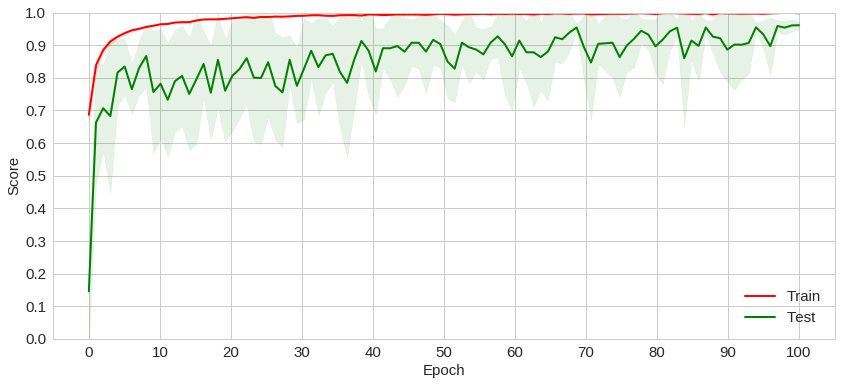

In [30]:
plot_mean_acc(history)

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

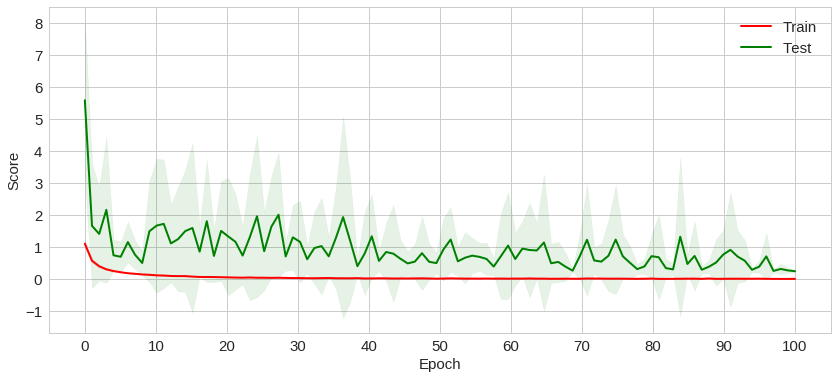

In [32]:
plot_mean_loss(history)

In [34]:
hist = [{'val_loss': [10.032479166984558, 7.25446912040934, 5.611573495960329, 3.318602446670411, 1.2810774010722525, 0.5596845358891613, 1.0956541214836761, 0.3077448972617276, 0.24326672608458466, 4.969384912550595, 0.3869512124419998, 7.23451826730161, 3.1214877613820136, 0.5079890467459336, 0.7209909317566598, 3.7684886579445447, 0.6446662180302951, 0.8911112088535447, 2.3375591267758864, 0.6871061030687997, 2.6339269139207317, 5.333094822628482, 0.18474083056764812, 0.5632592836077492, 0.304136994713069, 0.1945284377253529, 1.5762475336669013, 0.20762663843661144, 0.34901931607006986, 0.24838463171076341, 3.2495857675676234, 0.6744134222608409, 0.7514679766100016, 0.3957961283579152, 0.2563606073117626, 2.6288795823127202, 2.5180774145410396, 0.22294252335080955, 0.4410059954669059, 0.2919882645992402, 3.114881873242325, 0.4156173684764326, 0.2851011543354085, 0.2230861430716451, 0.2410742713905556, 0.28209467463209137, 0.2764943171553158, 0.290974711979743, 0.37416572052430297, 0.8566971845943385, 1.0015220238419715, 0.32597439810174, 0.3003759080546402, 0.2661992808101852, 0.3916885390967817, 0.3008071232388332, 0.8764589614045235, 0.33043790544256924, 4.7440533456113485, 0.31979341533009453, 0.4149446812346014, 0.3539707522660258, 0.3193954649446269, 0.7462329632263334, 0.4127851109627727, 0.2575981339490876, 0.23422032339250665, 0.22866611409602156, 0.22024326799918503, 0.25274438018209056, 0.25301400310839073, 0.27305930733259, 2.1920014038560014, 0.3019163975288879, 0.303032570169532, 0.2838229779521697, 0.2843409372977015, 0.28218888830923694, 0.2763451661284888, 0.29299192058663737, 0.25508561034386235, 0.2775803137617485, 0.29167261984164883, 0.2793862252339605, 0.2677283721128405, 0.26801861596292875, 0.29557013352491524, 0.28436219696880105, 0.2352587214234747, 0.5010757746425156, 0.25098436075832353, 0.20124883295154739, 0.2439659507163756, 0.28771969074809567, 0.2442449588293405, 0.2270112108378699, 0.23063407800224045, 0.2364642838757307, 0.23028641095861424, 0.231532952085987], 'acc': [0.7771071116059783, 0.8919007902191437, 0.9139596136962248, 0.9353599649861364, 0.9424934153812198, 0.9524802458296752, 0.9569798069527737, 0.9606014048456623, 0.9659789289896482, 0.9663081651093983, 0.9725636523266022, 0.9712467077429405, 0.9723441616498765, 0.9753072870939421, 0.9762949957148457, 0.9803555750658473, 0.9813432835820896, 0.9800263389984278, 0.9816725197541704, 0.9850746268656716, 0.9835381915006227, 0.9877085162423178, 0.9865013169446883, 0.9830992099378484, 0.9911106233538192, 0.9907813871817384, 0.9875987708516243, 0.9893546971027217, 0.9904521510096576, 0.9929762949956101, 0.9924275680421423, 0.9894644424934153, 0.9914398595258999, 0.9963784021071115, 0.9969271290605795, 0.9911106233538192, 0.9895741878841089, 0.9952809482001755, 0.992208077260755, 0.9930860403863038, 0.9935250219490781, 0.9949517120280948, 0.9937445127304653, 0.9989025460930641, 0.9978050921861282, 0.9877085162423178, 0.9953906935908692, 0.9967076383838537, 0.9981343283582089, 0.9987928008070318, 0.9942932396839332, 0.9874890254609306, 0.9963784021071115, 0.998244073853564, 0.9991220368744512, 0.9972563652326603, 0.9940737489025461, 0.9974758560140474, 0.9940737489025461, 0.9963784021071115, 0.9991220368744512, 0.9952809482001755, 0.990891132572432, 0.9974758560140474, 0.9980245829675154, 0.9976953467954346, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9996707638279192, 0.9996707638279192, 0.9886962248632215, 0.9901229148375769, 0.9981343284628703, 0.9993415276558385, 0.9997805092186128, 0.9998902546093064, 0.9997805092186128, 0.9998902546093064, 0.9996707638279192, 0.9998902546093064, 0.9998902546093064, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9998902546093064, 0.9780509218612818, 0.9967076382791923, 0.9971466198419666, 0.9987928007023705, 0.999451273046532, 0.9995610184372257, 0.9996707638279192, 0.9998902546093064, 0.9997805092186128, 0.9997805092186128, 0.9998902546093064, 0.9997805092186128, 0.9997805092186128], 'loss': [0.8028443092259532, 0.3806535368613552, 0.2916423231101643, 0.2217282553622867, 0.20094345548599826, 0.16083022698930108, 0.14666232372011867, 0.12940039106132012, 0.11580854801819239, 0.10351968037260531, 0.08446208941316866, 0.08892945665579953, 0.08653997065854292, 0.07728753081679056, 0.07331416263536135, 0.0664873830998632, 0.05607752275102894, 0.05891329659491653, 0.05922233483202582, 0.04673075886942852, 0.04860030783895735, 0.03927440235043342, 0.0482654119848909, 0.046947568786045155, 0.02723452035432536, 0.029803352687606293, 0.0378711325282493, 0.0338914978579672, 0.03135106142226417, 0.02127719894886594, 0.02458267818238072, 0.032469641251431876, 0.028121411248178307, 0.011367271383928403, 0.010188349268496379, 0.02823493156300635, 0.03318814668220721, 0.015145839136199385, 0.029523520905557096, 0.023009927711016506, 0.01892884183186546, 0.015309737749398316, 0.021351725603066446, 0.005345099620848953, 0.00858884333898296, 0.038126753035475296, 0.015964725829329073, 0.010750305393388622, 0.005780931706937877, 0.005793124193440649, 0.018922126084978834, 0.0484423652210285, 0.011231162906063892, 0.007090234478706052, 0.003987107506113768, 0.009837821893348588, 0.017317669675786396, 0.007181069998461442, 0.017967522632745828, 0.010539490755956116, 0.004144296115168859, 0.012360250953776755, 0.03276967972531987, 0.010430865996790955, 0.004991070837794682, 0.0075462906872921735, 0.001743083791337838, 0.0011317056355888825, 0.0011995557870948886, 0.0011758140246404304, 0.001354657714282327, 0.00191161884230647, 0.04459622486970639, 0.03169407914751529, 0.008099339932985224, 0.003466307693876433, 0.001057797264380318, 0.0009413523675906971, 0.0007660995214647382, 0.0008394366969960726, 0.0017170406443969132, 0.0010598492575421288, 0.0007855522998516623, 0.0014369068954621855, 0.0010892090855664444, 0.0009277053529803883, 0.0006645724803656633, 0.08103469631712512, 0.013317541435260335, 0.009646098441231488, 0.0050176148792308185, 0.0023442672612972153, 0.0015783830505970208, 0.0012577842038113244, 0.0013381751941587288, 0.0009005759907623264, 0.0009580396390016085, 0.000838792650114503, 0.0009573853422086739, 0.0008615494023570097], 'val_acc': [0.1240234375, 0.3125, 0.4033203125, 0.478515625, 0.7041015625, 0.8447265625, 0.7412109375, 0.91796875, 0.9375, 0.359375, 0.9228515625, 0.296875, 0.4453125, 0.8603515625, 0.7607421875, 0.5244140625, 0.8603515625, 0.7646484375, 0.6025390625, 0.85546875, 0.4853515625, 0.4482421875, 0.9580078125, 0.880859375, 0.9326171875, 0.951171875, 0.689453125, 0.9580078125, 0.9326171875, 0.9423828125, 0.53125, 0.876953125, 0.8046875, 0.9287109375, 0.9580078125, 0.6201171875, 0.6318359375, 0.958984375, 0.912109375, 0.9443359375, 0.6572265625, 0.91796875, 0.9580078125, 0.962890625, 0.9560546875, 0.943359375, 0.955078125, 0.958984375, 0.9482421875, 0.7861328125, 0.7587890625, 0.9453125, 0.9453125, 0.958984375, 0.892578125, 0.9541015625, 0.8642578125, 0.9443359375, 0.4404296875, 0.9521484375, 0.92578125, 0.9296875, 0.9453125, 0.8466796875, 0.921875, 0.9609375, 0.96484375, 0.96484375, 0.9638671875, 0.962890625, 0.9599609375, 0.9599609375, 0.7021484375, 0.9384765625, 0.955078125, 0.9638671875, 0.9638671875, 0.9609375, 0.9609375, 0.96484375, 0.9638671875, 0.9638671875, 0.9619140625, 0.9619140625, 0.9638671875, 0.966796875, 0.962890625, 0.9541015625, 0.9638671875, 0.9150390625, 0.95703125, 0.9677734375, 0.9599609375, 0.962890625, 0.9619140625, 0.9677734375, 0.966796875, 0.966796875, 0.9658203125, 0.96875]},
{'val_loss': [1.447103339165391, 0.8102837455679468, 0.7966179827013128, 0.5385361299692425, 1.712334899451195, 0.3436626166309396, 0.4843682352892705, 1.0945743521139637, 0.35252430010666713, 0.1961755785914131, 0.24689471221815087, 2.4410340410388884, 0.8723986705454384, 0.41676126442402656, 0.20845531422447564, 0.5878096736895573, 0.20817625457206795, 1.0531496760688737, 0.1825788121630061, 5.574231139322955, 0.3255973198324691, 0.3439885034377836, 0.2705966040002033, 0.3867570032318234, 0.2438789454983115, 4.371265296250174, 0.32530921708506305, 0.347921915166473, 0.9361468742277159, 0.7613607924137428, 0.5006894329379958, 0.6711836644275654, 0.4215272365195544, 0.2581229494181961, 0.3141741654530649, 1.517599481571791, 1.7211536368535103, 2.308237016149162, 0.8319126435356974, 0.25091342552958706, 0.6055755409330755, 0.7376922877700662, 0.22406745063868413, 0.20835206059307718, 1.8013568181700483, 0.19822130126860266, 0.2249419146564784, 4.150571009111381, 0.23217770811452318, 0.26201919614659086, 0.208168299285537, 1.0655008924614917, 0.21088803416482635, 0.8264777532733629, 0.42738947434281993, 0.4765398146030048, 0.1863020676142098, 0.20105851068385622, 0.1782269727580039, 1.4316983455295282, 0.20693126573105083, 2.086632798352289, 0.25704210415165063, 0.2514430122077539, 0.3133089990818287, 2.305035269612913, 0.26786060393808425, 0.16879111464691487, 0.272305703140801, 0.37104222814859844, 0.34896816219223, 0.600867350777881, 0.24435337094152748, 0.23991431450364092, 0.2001780806880171, 1.3820375113551178, 0.2716328620739483, 0.19059017894730518, 0.18480563792570615, 0.3323033753085286, 0.20701852909573287, 0.17051448516101436, 0.16591479883699226, 2.7038652437216, 0.19659098340428682, 0.24817177152510417, 0.19222290889021515, 0.3498763857734633, 2.6884792341909782, 1.178272505840077, 0.2137018580130764, 1.6436479381385734, 0.2897547719842444, 0.3348309727004398, 0.29508611691189907, 1.7321517905931183, 0.3707520445067532, 0.2137327492430967, 0.5033197510350476, 0.1856040297641121], 'acc': [0.6644722407183836, 0.829712530212599, 0.8797454466703615, 0.9096993637995315, 0.9244020189767034, 0.9364713628302025, 0.9495281983761247, 0.9521615097651964, 0.9546850998463902, 0.9592933949603829, 0.9651086241863578, 0.9660961158657011, 0.9696071978093553, 0.9704849683639379, 0.9725696731220611, 0.9722405091068685, 0.9784946237474725, 0.9811279350449857, 0.9802501645819618, 0.9807987711213517, 0.9782751811317166, 0.9836515251261795, 0.9854070660522274, 0.9879306561334211, 0.9839806890498135, 0.985077902220152, 0.9899056397667835, 0.9910028527540048, 0.9899056397667835, 0.9902348035988588, 0.988369541364933, 0.988259820057055, 0.9931972789115646, 0.9912222953697608, 0.9904542463061735, 0.9937458854509545, 0.9936361642346352, 0.9930875576036866, 0.9916611806012727, 0.9911125740618828, 0.9947333772218565, 0.9944042132982225, 0.9930875576036866, 0.9960500329163924, 0.9928681149879307, 0.9948430985297345, 0.995611147776439, 0.9947333772218565, 0.9897959183673469, 0.9931972789115646, 0.9973666886109283, 0.9971472459951722, 0.9992319509364127, 0.9965986394557823, 0.9916611806012727, 0.9931972790031233, 0.9928681150794892, 0.9978055738424402, 0.9982444590739522, 0.9950625411454904, 0.9928681149879307, 0.9965986394557823, 0.9969278033794163, 0.9981347377660742, 0.9957208689927584, 0.9976958525345622, 0.9922097871406628, 0.9980250164581962, 0.9972569673030502, 0.9963791969315849, 0.9960500329163924, 0.9970375246872942, 0.9976958525345622, 0.9980250164581962, 0.9983541804733888, 0.9925389510642967, 0.9969278033794163, 0.9975861312266843, 0.9989027869212201, 0.9993416721527321, 0.9993416721527321, 0.9995611147684881, 0.9995611147684881, 0.9916611806012727, 0.9924292297564187, 0.9967083607636603, 0.9978055738424402, 0.999231950844854, 0.9978055738424402, 0.9962694755321484, 0.9976958526261208, 0.9972569673030502, 0.9953917050691244, 0.9985736229975861, 0.9975861312266843, 0.9971472459951722, 0.9967083607636603, 0.999012508229098, 0.9974764099188063, 0.9978055738424402], 'loss': [1.1541307024822858, 0.5949851441257795, 0.4216514463772082, 0.3121929481896963, 0.25564718499554073, 0.2155410132309782, 0.1783744974475904, 0.16146245238444562, 0.1512091926037235, 0.136725589762151, 0.10859408069770667, 0.10550702290986749, 0.09837583795113014, 0.09588219434356439, 0.090393454684993, 0.0862232663455941, 0.06724553013419488, 0.05893563475056793, 0.06101327332888115, 0.05802675120700915, 0.06223996926051239, 0.05065793112757873, 0.04565074018433458, 0.03982338415939481, 0.04834995764032389, 0.042983442268932935, 0.034022022605830114, 0.027487639421366183, 0.029843524449456066, 0.03034311159087418, 0.03664119227331345, 0.03866121593678531, 0.023353500917338493, 0.02385198705507692, 0.028938994296134727, 0.018448154943962375, 0.017915297019774543, 0.02376467513679306, 0.025582298319251334, 0.03064163038732935, 0.018337211758755415, 0.01943289180274375, 0.022407117240544346, 0.01185026025183417, 0.025944320293850673, 0.016067425639732236, 0.013332086463189396, 0.015640744274924952, 0.032510408929560704, 0.018402704454452926, 0.00884883684588535, 0.011708286937634168, 0.0029002608115856125, 0.009904566080302579, 0.02721125552571344, 0.021900120770261558, 0.022453173226688376, 0.007506465917012212, 0.006571868799289283, 0.01574194404342216, 0.024455929320104125, 0.010854372684770712, 0.012336900244958385, 0.007258712376670927, 0.013901209497861942, 0.008527658178927493, 0.024411503506723158, 0.007285511468959614, 0.00947096111897512, 0.013523711330702159, 0.01498100255062136, 0.008347262383694667, 0.009096646146599566, 0.006369889790139123, 0.006697976188526497, 0.024776292509002974, 0.011495963844834155, 0.010000861502250578, 0.004032263530183715, 0.0024967393718770665, 0.0028149933578842964, 0.0016539956770466975, 0.0010776432906671692, 0.03328986815380039, 0.021208340360638307, 0.01353782345478552, 0.005415938367627375, 0.0030602797085009033, 0.007182453093592597, 0.009994979832996317, 0.008994673543744768, 0.007989497808332476, 0.013189602465754457, 0.005234728352344542, 0.007125102084577961, 0.008271386971951617, 0.009407763146831647, 0.0035688985087857362, 0.007872482216817443, 0.008785777550299497], 'val_acc': [0.6252446188618759, 0.8062622309197651, 0.7573385527922449, 0.8590998043052838, 0.6800391396431074, 0.9119373786239475, 0.8747553825378418, 0.7984344436697763, 0.9138943257863741, 0.9481409011288399, 0.9295499021526419, 0.6448140908360714, 0.7270058708414873, 0.8943248532289628, 0.949119373776908, 0.8454011751014425, 0.9481409001956947, 0.7661448150231647, 0.9559686897785463, 0.45596869047840516, 0.923679060665362, 0.9403131115459883, 0.9432485332227734, 0.9099804305283757, 0.9452054806184862, 0.4080234849989531, 0.9138943262529466, 0.9138943257863741, 0.7925636027657122, 0.83170254473117, 0.8835616452353341, 0.8835616447687615, 0.9295499021526419, 0.954990216197333, 0.9373776908023483, 0.7348336611241977, 0.7857142857142857, 0.6790606667617529, 0.8023483388111317, 0.9569471624266145, 0.8590998043052838, 0.8287671242208163, 0.9608610567514677, 0.9598825831702544, 0.6555773001127747, 0.9598825831702544, 0.9628180039138943, 0.5577299432745185, 0.9520547954536931, 0.9667318982387475, 0.9686888454011742, 0.8111546002255494, 0.9628180039138943, 0.8698630156815635, 0.9041095913739587, 0.9070450097847358, 0.9647749510763209, 0.9667318982387475, 0.9686888454011742, 0.8180039155273289, 0.961839530332681, 0.762230921164884, 0.958904109589041, 0.9598825831702544, 0.952054794520548, 0.7289628187037728, 0.9471624266144814, 0.9706457925636007, 0.9530332681017613, 0.9334637992769305, 0.938356166366495, 0.8806262240251217, 0.9608610567514677, 0.9637964774951077, 0.9637964774951077, 0.7915851288345696, 0.9510763209393346, 0.9686888454011742, 0.9677103718199609, 0.9500978473581213, 0.9706457925636007, 0.9696673189823874, 0.9706457925636007, 0.5851272029652754, 0.9647749510763209, 0.952054794520548, 0.9706457925636007, 0.9266144814090019, 0.6144814090019569, 0.7729941291585127, 0.9667318982387475, 0.764187866927593, 0.9530332681017613, 0.9442270068039866, 0.9530332681017613, 0.7309197660994856, 0.9148727993675874, 0.9637964774951077, 0.9050880626223092, 0.9686888454011742]},
{'val_loss': [3.9376798293169806, 0.7137479071596674, 0.6573067203967594, 0.46865438930325065, 0.47073627505000615, 1.5540054524227218, 0.6835745426351387, 1.248155180175387, 0.23467988923222555, 0.933164790769418, 1.299177314903514, 1.456385955612595, 0.26277450261454316, 1.2372906998784838, 6.8848389824696845, 0.29324840727637697, 0.46717105475208703, 0.3302414889211493, 0.2844919166941116, 0.2505557381570671, 0.3481919696956289, 0.2618380798058926, 0.30108602773406723, 1.2282659036008208, 5.026097420208808, 0.2062226940414357, 0.15842980900016818, 3.814009764246236, 0.2475315741863668, 0.7095968246592569, 1.5218025398744823, 0.39765750557120305, 0.21488033616133537, 5.4530931311568205, 1.9254225779864902, 0.2758107134655481, 0.6165521236620478, 0.24352838036928354, 0.2711479089713057, 0.2368940146643367, 0.3179799224755626, 0.8255849427415752, 1.8696250891071744, 0.22170290374117887, 0.3569783486640446, 0.24203181713053745, 0.5136465949628036, 0.36756702530056273, 2.1291935080615576, 0.2430711145877525, 2.151962835119533, 0.7212307818741179, 1.1578877361307283, 0.2695133957202727, 0.8896909455312233, 1.27571897141264, 0.4828749216517762, 0.966587132816609, 0.2421943481551388, 0.4307058765543152, 1.0364801117018156, 0.25170612759714406, 0.2388596719078921, 0.2855455233553322, 0.92845602645228, 0.33203296188297043, 0.9122066848682652, 0.2834253265009439, 0.26657242102184425, 2.1637931738423575, 0.22119650701518492, 0.581106413354681, 0.19765805340189752, 0.28262990765082685, 6.035676906385754, 1.2728698316300555, 0.24595087613802208, 0.20020036307701805, 0.1939383964966055, 0.22004961606200737, 0.25013216655411225, 0.19097313383430867, 0.21219488832017333, 8.438399592436411, 0.2556070263842212, 0.2561427121050451, 0.19689927283405706, 0.183379793101706, 0.27017915270921283, 1.873568648722607, 0.8470691157333508, 0.5197045609076133, 0.22761981877717036, 0.2779427889184387, 0.874837900567433, 0.4131937516069559, 0.35030210730442823, 0.4440175298573676, 0.21458050852432137, 0.2993159484734861], 'acc': [0.6721149627029399, 0.8237165423954407, 0.8817463802527629, 0.9109258447733298, 0.9212373848702103, 0.9397762177962387, 0.9442738043001316, 0.9481132075994775, 0.9589732338745064, 0.961715664765248, 0.9642387012893456, 0.9657744624835454, 0.9693944712593243, 0.9741114524960152, 0.9737823607891262, 0.9754278192189557, 0.9829969284774024, 0.9779508557430533, 0.9854102677135627, 0.978828433575783, 0.9814611671785871, 0.9865072400175515, 0.9881526985519965, 0.9792672225706093, 0.9876042123738482, 0.9899078543220711, 0.9929793769197016, 0.9858490566037735, 0.9897981571910569, 0.9921017990346643, 0.9868363317244405, 0.9925405879771829, 0.9928696797363796, 0.991553312856516, 0.9871654234313295, 0.9930890741553313, 0.9927599824484423, 0.9910048266783678, 0.9887011847301448, 0.9936375603334796, 0.9959412022817025, 0.9948442299254059, 0.9910048266783678, 0.9928696796840719, 0.9942957437472576, 0.9973672663448881, 0.9984642387011847, 0.9866169372531812, 0.9939666520403686, 0.9974769635805177, 0.999012724879333, 0.9949539271610356, 0.9888108819657745, 0.9972575691092584, 0.9968187801667397, 0.9971478718736287, 0.9938569548047389, 0.9964896884598509, 0.998354541465555, 0.9992321193505924, 0.9940763492759982, 0.9923211935059236, 0.9957218078104432, 0.9953927161035542, 0.9976963580517771, 0.9974769636328255, 0.9946248355064543, 0.9965993856954805, 0.993747257621417, 0.9951733216322949, 0.998025449758666, 0.9975866608161474, 0.9987933304080737, 0.999341816586222, 0.9939666520926763, 0.9923211935582313, 0.9972575691092584, 0.9992321193505924, 0.9995612110574813, 0.999670908293111, 0.999341816586222, 0.999341816586222, 0.9995612110574813, 0.9941860465639356, 0.9853005704256252, 0.9964896884598509, 0.998683633172444, 0.9992321193505924, 0.998683633172444, 0.9945151382185169, 0.9975866608161474, 0.9960508995173322, 0.9972575691092584, 0.9975866608161474, 0.9984642387011847, 0.9971478718736287, 0.9974769635805177, 0.9987933304080737, 0.9979157525230364, 0.9992321193505924], 'loss': [1.1611678665695926, 0.6268379070116481, 0.4097668548956834, 0.3093993009287519, 0.26024496259789764, 0.21389308894161804, 0.18616504655164445, 0.1628683595842518, 0.1325998591988978, 0.12310092453201216, 0.11742357525544608, 0.10705116394042524, 0.09669529790808204, 0.08651464852615177, 0.07713392622010418, 0.07695266213545926, 0.052970927285488995, 0.0696846986998211, 0.04875146660168327, 0.0621840142272658, 0.054553207183708714, 0.04062736508554602, 0.03661241403794363, 0.06136692772583056, 0.038826134706532296, 0.03310745697909457, 0.02690937574266302, 0.043824466529125354, 0.03359302862539369, 0.025686134959494646, 0.04268877856036384, 0.02202332085290165, 0.02173206888739663, 0.02918670530287535, 0.038197954712930485, 0.022549733847652256, 0.018252923889403378, 0.027275137168858134, 0.032260892215658296, 0.018310636242378803, 0.015409082872997406, 0.01553493411124773, 0.02784027678776776, 0.02160379554513797, 0.02008331450937641, 0.009291887022776314, 0.006018227561945376, 0.04351808404108967, 0.019172266917449426, 0.006771773484835442, 0.005816207084270177, 0.018956318556379446, 0.035423308768554436, 0.010985951401931314, 0.01160829167117278, 0.00840291574677506, 0.017285220242125754, 0.01258473798627437, 0.005324353007125226, 0.004045755715439358, 0.02156632487283774, 0.023736003155114583, 0.014177264079214975, 0.013855714339790205, 0.006809458487684945, 0.009579306733250427, 0.01558275068754343, 0.010456225398561466, 0.019420715409666108, 0.015453705406570019, 0.005694557490763501, 0.007846254083776504, 0.00374143884100636, 0.00226749558844181, 0.0220755319835339, 0.023035171393934083, 0.009680211303732322, 0.0033433194662826357, 0.002205533210579488, 0.0016506445585313958, 0.0020925709797603004, 0.0018736797899084343, 0.0019046991671333377, 0.021372749153917583, 0.04884045703234739, 0.011625296915834468, 0.003930410961383873, 0.0025844608827483946, 0.003758909455608166, 0.018525733313884164, 0.006349230080902814, 0.014819778471018345, 0.008903652069673003, 0.008923611457755852, 0.004629437414033144, 0.009091595625900287, 0.007373199457419513, 0.004901922590344353, 0.009241109759867232, 0.002095438573339426], 'val_acc': [0.09705882352941177, 0.779411766575832, 0.8000000007012311, 0.8676470602259917, 0.8558823548111261, 0.6745098043890561, 0.8088235317492017, 0.6990196087781121, 0.9372549028957591, 0.8039215688611947, 0.7568627465005014, 0.7392156867419972, 0.9313725504220701, 0.7029411774055631, 0.3872549033632465, 0.925490197948381, 0.901960785482444, 0.9313725504220701, 0.9303921587326948, 0.9450980406181485, 0.9245098053240308, 0.9431372558369356, 0.933333335203283, 0.7990196087781121, 0.5323529421114455, 0.962745099441678, 0.9686274514478795, 0.6009803930918376, 0.9617647068173277, 0.8176470588235294, 0.7441176479937983, 0.9245098053240308, 0.9539215695624258, 0.5607843151279525, 0.7705882352941177, 0.943137256304423, 0.8813725504220701, 0.9549019612518012, 0.9519607857161877, 0.9549019612518012, 0.9343137257239398, 0.8617647063498404, 0.7333333345020518, 0.9627450989741905, 0.9215686283859552, 0.9627450989741905, 0.8980392161537619, 0.9303921582652074, 0.7098039227373459, 0.9617647063498403, 0.7264705887027815, 0.8911764717569538, 0.7931372553694482, 0.9490196087781121, 0.8852941181145463, 0.7500000009349749, 0.9186274516816233, 0.7941176484612857, 0.9617647068173277, 0.933333333567077, 0.8529411778730505, 0.9647058828204286, 0.9598039225036022, 0.9529411774055631, 0.88039215779772, 0.9421568641475603, 0.8196078438384861, 0.9549019617192885, 0.9676470592910168, 0.7676470592910168, 0.9598039220361149, 0.9196078440722297, 0.9666666671341541, 0.9558823538761513, 0.5784313734839944, 0.8098039220361148, 0.9627450985067031, 0.9705882362290925, 0.9715686283859553, 0.964705883287916, 0.9627450985067031, 0.9715686279184678, 0.964705883287916, 0.3343137268926583, 0.9637254911310532, 0.9588235298792521, 0.9656862749772913, 0.970588235761605, 0.9588235298792521, 0.7323529411764705, 0.8235294131671681, 0.9176470597585042, 0.9656862749772913, 0.9549019617192885, 0.8303921563952577, 0.9254901965459188, 0.9421568632125854, 0.9372549033632466, 0.970588235761605, 0.9411764710557227]},
{'val_loss': [5.672540982877176, 1.0512611431202128, 0.8265961055005864, 0.5297557512081895, 0.8383620088648667, 0.4752407340401844, 1.9193135332169495, 1.1678033793770422, 0.30263321316621344, 0.2497965248528956, 1.3019565849557637, 0.6703502057985528, 0.8339609704897042, 0.3436084160492201, 1.6859445577766012, 0.774460476687486, 0.4323402809485148, 1.7333554288768394, 0.4452230447209367, 2.084076946058611, 0.4357239854976711, 0.33870857894431167, 0.41683354289747027, 0.36050503595089234, 0.5261917039082847, 1.416077621550071, 3.9004080666331795, 0.7502856919336625, 0.6970511915400078, 1.8542139971056792, 0.3351545742423438, 0.3486580929306342, 0.3218635149731165, 0.7734374219027356, 0.3613827171558216, 5.517151519232686, 1.6455914583877573, 0.6197019651014392, 0.7788224770929518, 4.629231538359575, 3.424546312159441, 0.5358685532885965, 0.2858925936271539, 0.51674158897416, 0.7926510092367507, 0.31772347247937516, 2.1055615517497794, 0.3060777629764629, 0.27895522009270296, 0.4582407244575236, 0.7140313562402613, 1.431407652262795, 0.8314357969000583, 2.9425430184626205, 0.284978481736151, 0.9762148548338808, 0.681552605446122, 0.4399818345580241, 0.3329593086285087, 0.3337124537923468, 0.34321279482091493, 0.3183803148700811, 0.2988455867935134, 0.27802826489557747, 0.2948173652634687, 0.30722150697422923, 0.2823966029405217, 0.2759849763658429, 0.26444687109171655, 0.26159498775403633, 3.557614614728721, 0.2770815654314196, 0.7250056609000239, 0.9495639550923227, 0.3588385309511956, 0.23393098371452098, 0.23801202266760155, 0.4832372899508923, 0.4017268779211792, 1.2117256621177506, 0.30588526541990313, 0.36163368073289437, 0.816290624462289, 0.32411200056126194, 1.1255810924165945, 0.36343579247156993, 0.27344943481976075, 0.2528708090139432, 0.2649754576442341, 0.2504271402816307, 0.2559356065312198, 0.26125113529273614, 0.2592563591362828, 0.2651802219981411, 0.38732634737747895, 0.32960784580077246, 0.2290093631622897, 0.2736303377777933, 0.29243775308628445, 0.26261885888993586], 'acc': [0.6675438596491228, 0.8337719298245614, 0.8807017543859649, 0.9093201754385964, 0.9294956140350877, 0.9394736842105263, 0.9456140350877194, 0.9475877192982456, 0.9582236842105263, 0.9591008771929824, 0.9652412280701754, 0.9643640350877193, 0.9707236842105263, 0.9705043859649123, 0.9739035087719298, 0.9765350877192982, 0.9783991228070176, 0.98125, 0.9790570175438597, 0.9835526315789473, 0.9828947368421053, 0.9831140350877193, 0.9842105263157894, 0.9824561403508771, 0.9875, 0.9885964912280701, 0.987719298245614, 0.9914473684210526, 0.9845394736842106, 0.9883771929824562, 0.99375, 0.9925438596491228, 0.9914473684210526, 0.9930921052631579, 0.987390350877193, 0.9900219298245614, 0.9940789473684211, 0.9916666666666667, 0.9932017543859649, 0.9948464912280702, 0.9890350877192983, 0.9892543859649123, 0.9947368421052631, 0.9946271929824562, 0.9971491228070175, 0.9978070175438597, 0.9896929824561403, 0.9927631578947368, 0.9950657894736842, 0.9921052631578947, 0.9960526315789474, 0.9974780701754385, 0.9939692982456141, 0.9925438596491228, 0.9985745614035088, 0.9983552631578947, 0.9956140350877193, 0.9907894736842106, 0.9939692982456141, 0.9948464912280702, 0.9972587719298246, 0.9979166666666667, 0.9981359649122807, 0.9991228070175439, 0.999671052631579, 0.9997807017543859, 0.9994517543859649, 0.9997807017543859, 0.9997807017543859, 0.999561403508772, 0.9851973684210527, 0.9885964912280701, 0.9953947368421052, 0.9973684210526316, 0.99375, 0.9974780701754385, 0.9994517543859649, 0.9991228070175439, 0.9971491228070175, 0.9963815789473685, 0.9969298245614036, 0.9976973684210526, 0.9974780701754385, 0.9950657894736842, 0.9953947368421052, 0.9970394736842105, 0.9984649122807018, 0.9991228070175439, 0.9994517543859649, 0.999561403508772, 0.999671052631579, 0.999561403508772, 0.9997807017543859, 0.999671052631579, 0.9868421052631579, 0.9922149122807018, 0.9963815789473685, 0.9972587719298246, 0.999671052631579, 0.999561403508772], 'loss': [1.1788780678782547, 0.587976509881647, 0.41312368381441683, 0.3183553996577598, 0.2441067325049325, 0.207573127811938, 0.18768461710005477, 0.1757323868442, 0.14114590407790323, 0.141419013566746, 0.1127435341787835, 0.10869770208537055, 0.0915733476921001, 0.09051583683886157, 0.082894542798596, 0.07927360370542788, 0.06888529225415958, 0.061796022707232875, 0.06076548675508157, 0.05040200655062667, 0.05311645580713, 0.04883250945253837, 0.047447010803009844, 0.052728561558883245, 0.03814558980183823, 0.03656919486953452, 0.03640293385307591, 0.0296072922391192, 0.048102961184371164, 0.036318187640848154, 0.018837987561454883, 0.023462362817372195, 0.027143559959260623, 0.0236053758122899, 0.03628922814826007, 0.034467818139181185, 0.02219715420362997, 0.028694247390644464, 0.019798960078537275, 0.015720739852341674, 0.03251083364085756, 0.03564769366820927, 0.01555765198942952, 0.013581200108736787, 0.01102827342783393, 0.007108048964194798, 0.03500223619662472, 0.023984490022810764, 0.014089604105889489, 0.023990865735418324, 0.012234452511690681, 0.007995355319801827, 0.019776164276516826, 0.02206865670656011, 0.006139995405619789, 0.006505919650427179, 0.01319919874376067, 0.02939291761820705, 0.01765878840535726, 0.015446060264443269, 0.008134807190671972, 0.00715711957509803, 0.006131158101245666, 0.0030826172567242935, 0.0018119436863270365, 0.0010660647074330067, 0.0017287758084086435, 0.0011968116307838372, 0.0014195223256469067, 0.0017347458069942852, 0.06077367283964393, 0.03373148605550931, 0.012490249703155872, 0.006884306663897932, 0.019079208493275743, 0.008299615337369016, 0.0019301289979474653, 0.004718307201407394, 0.010165568823162685, 0.01407680865173429, 0.00980703008818844, 0.00802447758517366, 0.008894591340954081, 0.014918996437151229, 0.014759484187382904, 0.009074651921989578, 0.00517555151910656, 0.0034859797915694863, 0.002170057936809188, 0.00152919231962929, 0.0015503658869817085, 0.0014061249674391387, 0.0008868748244207892, 0.001531448785338023, 0.044006960000281155, 0.022032251149038642, 0.01091002426152013, 0.011283048861122025, 0.0021095085067500212, 0.0015626427267562304], 'val_acc': [0.18405511811023623, 0.6811023622047244, 0.7637795275590551, 0.8533464566929134, 0.7982283464566929, 0.8799212603118476, 0.700787402513459, 0.764763779527559, 0.9320866141732284, 0.9409448818897638, 0.7785433070866141, 0.8454724409448819, 0.7391732283464567, 0.9232283464566929, 0.5974409453512177, 0.7706692913385826, 0.9133858267716536, 0.670275591020509, 0.8986220472440944, 0.6240157480314961, 0.9143700787401575, 0.9350393700787402, 0.9232283464566929, 0.9340551181102362, 0.9015748031496063, 0.6968503937007874, 0.5236220472440944, 0.8041338582677166, 0.797244094488189, 0.6023622056630653, 0.9478346456692913, 0.9370078744850759, 0.9320866141732284, 0.844488188976378, 0.9330708661417323, 0.4153543307086614, 0.6791338582677166, 0.8769685039370079, 0.7972440949575169, 0.48326771653543305, 0.5826771653543307, 0.9035433070866141, 0.952755905511811, 0.9124015748031497, 0.7874015748031497, 0.9498031496062992, 0.6850393700787402, 0.9517716535433071, 0.9507874015748031, 0.9281496062992126, 0.8336614173228346, 0.6968503937007874, 0.8031496062992126, 0.6112204724409449, 0.9517716535433071, 0.8031496062992126, 0.8671259842519685, 0.937007874015748, 0.9478346456692913, 0.9488188976377953, 0.9409448818897638, 0.9468503937007874, 0.9498031496062992, 0.9616141732283464, 0.9566929133858267, 0.9557086614173228, 0.9625984251968503, 0.9586614173228346, 0.9576771653543307, 0.9606299212598425, 0.5226377962142463, 0.9507874015748031, 0.8031496062992126, 0.8572834645669292, 0.9389763779527559, 0.9645669291338582, 0.9655511811023622, 0.9163385826771654, 0.9350393700787402, 0.7883858267716536, 0.9507874015748031, 0.9429133862960996, 0.8868110236220472, 0.9498031496062992, 0.8159448818897638, 0.937007874015748, 0.9625984251968503, 0.9625984251968503, 0.9625984251968503, 0.9645669291338582, 0.966535433540194, 0.9645669296031861, 0.9655511811023622, 0.968503937477202, 0.9409448818897638, 0.9448818897637795, 0.9557086614173228, 0.9586614173228346, 0.9596456692913385, 0.9616141732283464]},
{'val_loss': [6.7361519411792905, 0.47826656106654114, 0.887637860596356, 2.7271640722705857, 0.26616142893771044, 0.2901651928949309, 0.8776218540871179, 0.34523072111325004, 0.3468445435049027, 3.8947500008319715, 2.936594030418338, 0.5441627196672438, 3.854495177665124, 2.9000373910379222, 0.7351726209253254, 0.2372288175051155, 2.795845893482993, 0.8130683606769157, 0.16292491553472283, 1.101620260892939, 0.3639371188180558, 0.4001995304585769, 3.3080998797704235, 7.032981774624892, 5.234174132586325, 0.19100015938400206, 1.341133834625499, 3.515284084597617, 1.730722203980052, 3.7565119818263635, 0.35627379688775734, 0.5494606914196668, 3.8273019704190414, 0.26684476451352, 0.5514095237845964, 0.591687028861883, 0.30113525326528434, 0.281978110531667, 0.5104159888771077, 0.7305221536536389, 0.40849896684876136, 0.2875508107208016, 2.8344033880743456, 0.29278448646262556, 0.359318584181262, 0.5577659658026285, 0.2736096426056889, 0.164790948868931, 0.22083598177807995, 0.489749481612035, 3.370469991675043, 3.493897529564249, 0.2164200277714481, 0.35204640860543684, 0.4670131937469261, 1.2760637730372448, 1.9811163363781987, 0.2974023658130691, 0.24037492266454566, 0.34784697037517387, 0.3471625874983118, 2.485532714486242, 5.104754238974946, 3.2791571521642697, 0.23767025530930894, 0.32448597942462626, 0.3802461917224804, 0.25413876255199974, 0.3029078041521971, 1.3804981197466428, 5.5899729904741955, 1.5670009616747265, 0.3120341763698645, 0.2830719523572902, 1.5901464103895475, 2.3922365244397663, 0.4952177311539044, 0.6993133838092683, 0.30554774521433375, 0.27019063575532104, 0.20758973863622338, 0.2245646164627133, 0.21614371336123103, 0.2407449686898177, 0.8023478544003689, 3.9010599601691487, 0.24683894703417225, 0.6000844966379693, 0.2498132853813571, 0.37760385516406053, 0.315743579569402, 0.3015997181727306, 0.7348000795075312, 0.2690874195705197, 0.3750358912552692, 0.4011209382690156, 0.24629831337356686, 0.23137322578089947, 0.2354889523369916, 0.23961789838588946], 'acc': [0.6832236842105263, 0.8520833333333333, 0.893969298245614, 0.9153508771929825, 0.925219298245614, 0.9357456140350877, 0.9479166666666666, 0.9506578947368421, 0.9592105263157895, 0.9578947368421052, 0.9584429824561403, 0.9611842105263158, 0.9692982456140351, 0.9672149122807018, 0.9668859649122807, 0.975219298245614, 0.9736842105263158, 0.9774122807017543, 0.9763157894736842, 0.9770833333333333, 0.9831140350877193, 0.9842105263157894, 0.9853070175438596, 0.9849780701754386, 0.9845394736842106, 0.9849780701754386, 0.9865131578947368, 0.981140350877193, 0.9882675438596491, 0.9900219298245614, 0.9899122807017544, 0.993530701754386, 0.9919956140350877, 0.9883771929824562, 0.9856359649122807, 0.9888157894736842, 0.9913377192982457, 0.993421052631579, 0.9904605263157895, 0.9949561403508772, 0.994188596491228, 0.9889254385964912, 0.9911184210526316, 0.9945175438596491, 0.9951754385964913, 0.9970394736842105, 0.9902412280701754, 0.9913377192982457, 0.9956140350877193, 0.9959429824561403, 0.9917763157894737, 0.9915570175438596, 0.9960526315789474, 0.9970394736842105, 0.9917763157894737, 0.9959429824561403, 0.9964912280701754, 0.9993421052631579, 0.9994517543859649, 0.9929824561403509, 0.9953947368421052, 0.9950657894736842, 0.9895833333333334, 0.9955043859649123, 0.9990131578947369, 0.9968201754385965, 0.9963815789473685, 0.9936403508771929, 0.9982456140350877, 0.9970394736842105, 0.9933114035087719, 0.9946271929824562, 0.9944078947368421, 0.9964912280701754, 0.9992324561403508, 0.9992324561403508, 0.9980263157894737, 0.9947368421052631, 0.988048245614035, 0.9987938596491228, 0.9997807017543859, 0.999561403508772, 0.999561403508772, 0.999561403508772, 0.9967105263157895, 0.9921052631578947, 0.9963815789473685, 0.9994517543859649, 0.9993421052631579, 0.9966008771929824, 0.9928728070175439, 0.9986842105263158, 0.9956140350877193, 0.9974780701754385, 0.9969298245614036, 0.9984649122807018, 0.999561403508772, 0.999561403508772, 0.999671052631579, 0.999671052631579], 'loss': [1.1271364293600383, 0.522870838485266, 0.36782675392010755, 0.2849712108572324, 0.24529071650222728, 0.20753746312111615, 0.17897661128980025, 0.16166882572466867, 0.1366706086976225, 0.13650415016240194, 0.13367677089153673, 0.12454408489723216, 0.09601602469767002, 0.09340138028522856, 0.09788009198382497, 0.08109343020049364, 0.0795005411555043, 0.070408609381207, 0.07034937687904427, 0.07589351719351518, 0.05424703083005162, 0.049591960667953176, 0.0436105744359737, 0.052331664845175846, 0.0456333545315398, 0.04043771468568593, 0.042591232947980694, 0.05940843994428992, 0.03626892790392352, 0.03301172876575341, 0.030909544930041753, 0.02053363846227927, 0.026050600223192177, 0.03171634961194318, 0.044626822641932226, 0.03363945455966403, 0.026532462005400846, 0.020710461462971452, 0.03154530655676928, 0.016688489509078065, 0.02122990074552179, 0.03138306388874505, 0.02862952847928299, 0.016762569176953228, 0.015081688851192635, 0.009391781895982077, 0.034256648391703746, 0.027864649000944236, 0.012956454657353135, 0.013125566702671532, 0.02653468935490022, 0.024126225809787252, 0.01236988303899763, 0.008354475847393093, 0.025905232330287138, 0.013799940453387343, 0.009868194082838799, 0.002473603884576286, 0.0027302014024188108, 0.02293114879467363, 0.015078077852727769, 0.01784405957808766, 0.029144518979796485, 0.013085019087136237, 0.004728567386949802, 0.011147583728297992, 0.0113058413881079, 0.017653075604660746, 0.0070836146190965356, 0.010301981680012224, 0.0191551910174958, 0.013838277810587067, 0.01789545799956454, 0.011093378453360378, 0.0031314205424047958, 0.00356789650034866, 0.0076044136704192505, 0.0134168249800017, 0.04030733389137599, 0.0045377851379797855, 0.0013515466673516927, 0.00188954206293817, 0.0022809855473808153, 0.0014518593708735832, 0.011772945818748076, 0.024391204370093827, 0.011217095708005281, 0.0031576235081478155, 0.0031363106698535648, 0.010727763153094951, 0.02858380028037732, 0.004612833526588427, 0.014592484708098135, 0.008918402652795377, 0.008592269219384194, 0.004940203808078286, 0.001704583164675106, 0.0015623987803880018, 0.0015583289556965402, 0.0015924874238957424], 'val_acc': [0.06594488188976377, 0.8454724418835378, 0.7519685044063358, 0.5629921262189159, 0.9330708666110602, 0.9114173237733015, 0.7706692918079106, 0.9124015752724776, 0.8996063001512542, 0.577755905746475, 0.5797244096834828, 0.779527559524446, 0.5875984254315143, 0.6102362207071049, 0.7677165359023987, 0.920275591489837, 0.655511811258286, 0.8336614173228346, 0.9527559064504668, 0.7716535437764145, 0.9183070870835012, 0.8996062996819263, 0.4704724409448819, 0.30019685062836476, 0.4724409451165537, 0.9606299217291704, 0.7696850393700787, 0.6043307091307453, 0.7411417327527925, 0.5974409453512177, 0.9311023626740523, 0.8877952760598791, 0.5777559059811389, 0.9537401579496428, 0.857283465505585, 0.8887795275590551, 0.9448818907024353, 0.9458661422016114, 0.8966535437764145, 0.8651574807842886, 0.9212598434583409, 0.9320866146425563, 0.7244094492882256, 0.9537401579496428, 0.9251968513323566, 0.8602362209417689, 0.9409448828284196, 0.965551182041018, 0.9635826776346822, 0.9114173233039736, 0.6259842519685039, 0.6781496062992126, 0.964566930072514, 0.9488188981071232, 0.9104330713354697, 0.8405511815716901, 0.8031496067685405, 0.9606299217291704, 0.9694881894457059, 0.950787402044131, 0.934055119048892, 0.7381889768472807, 0.4173228351149972, 0.6151574807842886, 0.9606299217291704, 0.9566929138551546, 0.9271653548000366, 0.9527559059811389, 0.950787402044131, 0.7539370083433437, 0.48129921283308913, 0.7844488188976378, 0.9478346466079471, 0.9596456697606665, 0.8326771658236586, 0.7440944886583043, 0.9143700792094854, 0.8454724414142099, 0.9458661417322834, 0.951771654012635, 0.9694881899150338, 0.967519685978026, 0.9694881899150338, 0.9635826776346822, 0.8375984261355062, 0.624015748500824, 0.968503937477202, 0.8523622051937374, 0.9547244103874747, 0.9301181111748763, 0.9537401579496428, 0.9557086623559786, 0.8287401579496428, 0.9596456697606665, 0.9498031500756271, 0.9163385831464933, 0.968503937477202, 0.9704724414142099, 0.9704724414142099, 0.9724409458205456]},
{'val_loss': [9.376886965848808, 0.76317550579471, 0.4549493703596906, 0.3405257279217302, 0.24013958090932858, 0.3830496528021011, 1.034237483532917, 0.2526931411049648, 0.36035035257379716, 0.3614250093296172, 0.3331699928311798, 0.6931833300012248, 0.37665487357972466, 0.27987918137866563, 0.2935637930386472, 0.3316652759841462, 0.2023423968777383, 0.3965961235163088, 0.36217049144607394, 0.3740443956268915, 1.4070556767996028, 0.6048281336224434, 0.3892201886106555, 0.19228289763164053, 0.22419432188472482, 0.24900788464633833, 0.5949728344166403, 0.3052806450177489, 0.40222083172382295, 1.004421211300099, 0.5156809682988073, 0.19792640923144322, 0.3995739335686376, 0.7064292856585437, 0.6459475711832559, 0.3862346037681114, 0.33894654182552997, 0.3151472035259318, 0.26075364104941906, 0.16763313979271552, 0.5203825225259645, 0.23069968582872527, 0.24526181843379719, 0.27433712591217235, 0.40239441982044055, 0.1486212978936694, 0.1485014338113696, 0.3361986711956137, 0.3618678424847205, 0.28300151167635684, 0.22807233778776506, 1.1358678992828168, 0.19484938410054117, 0.34073026744120294, 0.7784639087789595, 0.4741161016860892, 0.3010178405313575, 0.18624246867544125, 0.4564988787513701, 0.7043789100805342, 0.2021039041828052, 0.3273013877843484, 0.1976252593022772, 1.022134753121215, 0.1895344021022241, 0.1603539733854781, 0.2867337227154382, 1.7205111073256545, 0.19783002541510142, 0.20391581428341415, 0.22003024930499465, 0.2325883622145403, 0.29692703456672753, 0.38070144808376216, 0.23054746650268498, 0.3630822106696857, 0.22267646783512385, 0.19864142566184348, 0.32543776780971284, 2.284034308106919, 0.26389237130100296, 1.1888147853482993, 0.30813993081376423, 0.22445615971808205, 0.4376703258442626, 0.17875251434303976, 0.5250189753754378, 0.35109315985246, 0.3373534647150231, 0.1941266350389718, 0.1508708141119628, 0.16231910226972607, 0.22459127739528054, 0.3052958565222943, 0.581841979762382, 0.18058247680796294, 0.196974379087412, 0.2919898128087354, 0.2081098730168621, 0.24118025642560187], 'acc': [0.6858082191911462, 0.8341917808251839, 0.8816438356164383, 0.9114520548010525, 0.9236164383692285, 0.9272328767123288, 0.9467397260273973, 0.9506849315199134, 0.9511232876712329, 0.9608767123287671, 0.9646027397260274, 0.9628493150750251, 0.9674520547945206, 0.9724931506881975, 0.9618630136986301, 0.9746849315068493, 0.9815890410958904, 0.9825753424657534, 0.984, 0.9797260273972602, 0.9845479452054795, 0.9858630136986302, 0.9858630137051622, 0.9783013698630137, 0.98805479452708, 0.9852054794520548, 0.9861917808284498, 0.989041095890411, 0.9907945205479453, 0.9918904109589041, 0.992, 0.9915616438356164, 0.9968219178082192, 0.9905753424722854, 0.9876164383626964, 0.9865205479452055, 0.9938630136986302, 0.9955068493281325, 0.9811506849315068, 0.9957260273972602, 0.9950684931572169, 0.9927671232876712, 0.9962739726027398, 0.992986301369863, 0.9924383561709156, 0.9888219178147512, 0.9953972602739726, 0.9967123287671232, 0.9952876712328768, 0.9952876712328768, 0.9958356164383562, 0.9923287671232877, 0.9947397260273972, 0.9945205479452055, 0.9957260273972602, 0.9946301369928334, 0.9953972602739726, 0.9975890411024224, 0.989041095890411, 0.9981369863013698, 0.9971506849315068, 0.9985753424657534, 0.9984657534246575, 0.9964931506914635, 0.9889315068493151, 0.9979178082191781, 0.9981369863046359, 0.9889315068493151, 0.9984657534246575, 0.9984657534246575, 0.9984657534377216, 0.9926575342465753, 0.9979178082191781, 0.9974794520613265, 0.9906849315068493, 0.9976986301369863, 0.9973698630136987, 0.9975890410958904, 0.9987945205479452, 0.9940821917808219, 0.9986849315068493, 0.9983561643835617, 0.9968219178082192, 0.9984657534246575, 0.9983561643835617, 0.9982465753424657, 0.9976986301435183, 0.9886027397260274, 0.9971506849315068, 0.9976986301369863, 0.9986849315068493, 0.9994520547945206, 0.9985753424657534, 0.9934246575342466, 0.9969315068493151, 0.9983561643835617, 0.9993424657534247, 0.9994520547945206, 0.9989041096021051, 0.9898082191846143], 'loss': [1.0910764155453199, 0.5760061708737726, 0.4136629987481522, 0.3124848880637182, 0.25778447485623296, 0.2410012981858972, 0.17686490950927342, 0.1639556245379252, 0.15837076981233, 0.12563759400664942, 0.11453837317799868, 0.11269120018776149, 0.10350811524668785, 0.0939160066540927, 0.12801928773644852, 0.08526805656423715, 0.05777104180398053, 0.057497424750958814, 0.05235567860335928, 0.05959961250332529, 0.04896741585928487, 0.04137816339914929, 0.044878368436677814, 0.07148943433473652, 0.036561243292607674, 0.04260465156307367, 0.04103511182106521, 0.03392402576234141, 0.027642357647827225, 0.02538492999521837, 0.02803125014276027, 0.025637956234894385, 0.012937258041591371, 0.032600012139557565, 0.04136643395011556, 0.0431954948949079, 0.01942159170328244, 0.013773005104394094, 0.06418254462234063, 0.013297586240984295, 0.01376247272935173, 0.022211355577746075, 0.012276503255131514, 0.02136274610374965, 0.0215858316908986, 0.03589588985155809, 0.013216119372257197, 0.010341288125104181, 0.01548442492356256, 0.015209092254214601, 0.012888030183750319, 0.022201188970902577, 0.019089597611343614, 0.017568092706587726, 0.01231827798076867, 0.019021594804989123, 0.013301734324997571, 0.008684207716607488, 0.03547521314689609, 0.007239981566925776, 0.010727109410806419, 0.005364850979335032, 0.005091734905286265, 0.012777767809688381, 0.033341328631563444, 0.007649337419729731, 0.006261770276400605, 0.03393341256839252, 0.005110354217509293, 0.006431659781367658, 0.005301777297044045, 0.027964028551705718, 0.0069098962506770525, 0.009737771582711578, 0.030499077706880012, 0.007846091500697146, 0.01010445605294798, 0.009104671035148523, 0.005050304140501707, 0.01963851519761813, 0.004244311773811454, 0.005586334180006317, 0.010929246260959986, 0.007245072149263363, 0.007254123632912524, 0.006154637943222092, 0.007385435976715773, 0.033378301985711754, 0.010005088203841795, 0.008070770976720506, 0.004671555484101266, 0.0021189899515457874, 0.005122976593486247, 0.021644913618038216, 0.010309577584473978, 0.0057838571671151705, 0.0027337027962960636, 0.002221297196604149, 0.004005638431410038, 0.032074133882557414], 'val_acc': [0.03857566765578635, 0.7457962421705886, 0.8704253208743359, 0.8921859553258803, 0.9317507422524555, 0.8911968356423986, 0.7794263104067123, 0.9277942631058358, 0.8882294761792606, 0.9000989119683481, 0.9080118698488947, 0.7893175074183977, 0.9188921863671934, 0.929772503298185, 0.9228486648063395, 0.909990109628551, 0.956478734339498, 0.8714144415600718, 0.9228486651011202, 0.9188921867798863, 0.76162215628091, 0.8892185958627423, 0.9099901092158581, 0.956478734339498, 0.950544015825915, 0.9554896142433235, 0.8664688427299704, 0.9446092981377177, 0.8951533135509396, 0.8160237391082281, 0.9119683485828215, 0.9624134524403882, 0.9327398619359372, 0.8595450053582913, 0.8862512368122972, 0.9218595454176385, 0.9307616229816666, 0.943620178454236, 0.9436201788669288, 0.9703264099082418, 0.8367952526382122, 0.9574678536102869, 0.9574678540229797, 0.9485657764589516, 0.9228486646884273, 0.9683481705412784, 0.9742828886421686, 0.9396636997203092, 0.9406528194037909, 0.9505440162386078, 0.9554896146560163, 0.7626112767897775, 0.9624134524403882, 0.9416419394999654, 0.8951533139636325, 0.8476755691565109, 0.9545004949725346, 0.9683481705412784, 0.9090009891196835, 0.8051434221772364, 0.9643916913946587, 0.9376854597637845, 0.9653808114908333, 0.803165182810273, 0.9713155295917235, 0.9683481705412784, 0.9436201788669288, 0.7626112767897775, 0.9683481705412784, 0.9713155295917235, 0.9535113752890529, 0.9624134524403882, 0.9584569732937686, 0.9248269044680836, 0.9614243327569065, 0.9406528194037909, 0.9624134524403882, 0.9643916918073516, 0.9386745800368275, 0.7378832847027349, 0.9505440166513007, 0.7675568747944931, 0.9327398615232443, 0.9624134524403882, 0.8635014840922182, 0.9703264099082418, 0.9198813060506751, 0.9386745796241345, 0.9416419390872726, 0.9723046492752052, 0.9752720083256503, 0.9723046492752052, 0.9653808114908333, 0.9515331359220895, 0.8733926809270351, 0.9693372902247601, 0.9732937689586869, 0.9416419390872726, 0.9673590508577967, 0.9604352130734248]},
{'val_loss': [5.123952401523193, 2.405311850360175, 2.138728444179293, 0.7749108125384605, 0.26559375665668394, 1.0381192728891835, 0.45301896117108886, 0.6734506497508038, 1.4591303003436864, 0.41819206336134723, 0.3424120765794124, 0.8395426210654738, 0.5750217016018389, 5.5764052559528405, 0.22303158489391217, 0.6443317871027588, 0.5750438962106356, 0.37594795555459676, 2.3597230414571047, 1.219201109486764, 0.4445556119046053, 0.42901700968845824, 0.2703664430045145, 0.5839216977919057, 0.45851894826752876, 0.34399379076153763, 3.3073480220831613, 0.43076875114490276, 0.4840623361375358, 0.634550417596697, 0.600700883860904, 1.3619627130235272, 0.7206194495000116, 0.577529530259002, 1.918966702834451, 0.27522760821157277, 0.49801677311522413, 0.5263699469299284, 0.2067216987833791, 0.3892775084324973, 1.073972445240639, 0.32000004397361376, 0.2484381733909995, 0.24900386782518139, 0.2765744853158121, 0.7622886095313693, 0.3092454265441055, 1.2242883712291437, 0.34860395938914907, 0.20134612165039661, 0.2211381086170693, 0.2423500413525182, 0.4061311661489968, 0.990418530498337, 1.198104894434806, 0.20005542923741151, 0.21836656569145688, 0.23168693195171552, 0.23841342153756548, 0.27603059993524576, 0.23097947775270355, 1.6407466633633014, 0.2839130425980039, 1.1424931658923856, 0.1905334922090771, 0.200462292620279, 0.2475971431381489, 0.21173254069501896, 0.3254426778190703, 1.7747415840578227, 0.3078317318954602, 0.6148907064317842, 0.33602272185563525, 0.2070421312973457, 1.9598614621840091, 0.471504516131718, 0.9110168654655127, 0.24877181053571246, 0.2723479243560611, 1.500876995410892, 0.23222054533640335, 0.33790407136924655, 0.33004000914786286, 0.38043652155443325, 0.3847616265616499, 0.5922455233533838, 0.5055447672691267, 0.4621321117782123, 0.29144913143849355, 0.32143528633684054, 0.21381712966215216, 0.4452052668196611, 2.4114338058694034, 0.25441090491065504, 0.2443344933335331, 0.2300105612654012, 0.26199144059602797, 0.2524688464715906, 0.24463058943232785, 0.2274070086393855], 'acc': [0.6919031445293315, 0.8358715898407841, 0.8760819546662012, 0.906321902048866, 0.9267009970417442, 0.9349183741072463, 0.9449983565245973, 0.9470800920346225, 0.955297469060941, 0.9516818232142914, 0.9625287608195464, 0.9665826668127534, 0.970636572858205, 0.9701983127116478, 0.9648296263832584, 0.9794017749534348, 0.9789635148460611, 0.9772104744296274, 0.9732661334502027, 0.9831269858661116, 0.98148351046346, 0.9845513312673209, 0.9846608962419195, 0.9841130711077024, 0.9844417662012939, 0.9808261203023995, 0.990686972770553, 0.9773200394956544, 0.9903582776900227, 0.9899200175434655, 0.9915634929330558, 0.9953982688725759, 0.9892626273693437, 0.9883861071545963, 0.9879478470472225, 0.995179138818889, 0.9955078338994193, 0.9934260983893941, 0.9859756766162854, 0.9921113180672729, 0.9927687082283335, 0.9956173989262628, 0.993645228443081, 0.9972608743289142, 0.9987947847047223, 0.9940834885504547, 0.9884956721814396, 0.9905774077437096, 0.9905774076914649, 0.9979182644899748, 0.9991234797852525, 0.9975895694094445, 0.9959460940590377, 0.9894817574360918, 0.9892626273693437, 0.999233044812096, 0.9978086994631313, 0.9990139147584091, 0.9997808699463131, 0.999233044812096, 0.9998904349731565, 0.9940834886026993, 0.9826887258109824, 0.9950695737920455, 0.9984660896241919, 0.9996713049194696, 0.9994521748657829, 0.9998904349731565, 0.9996713049194696, 0.9917826230389873, 0.9877287169935357, 0.9958365289799496, 0.9984660896241919, 0.9990139147584091, 0.9991234797852525, 0.9944121836309849, 0.9922208830941164, 0.9976991344362879, 0.9982469595835662, 0.9949600087652022, 0.9983565245973485, 0.9958365290321943, 0.9966034841678536, 0.9982469595705051, 0.9994521748657829, 0.9991234797852525, 0.9970417443274721, 0.9904678426646214, 0.9983565245973485, 0.999233044812096, 0.9984660896241919, 0.9980278295168182, 0.9956173989785074, 0.9934260983893941, 0.9986852196778788, 0.9995617398926263, 0.9994521748657829, 0.9998904349731565, 0.9995617398926263, 0.9997808699463131], 'loss': [1.0868562378313373, 0.5924781179642303, 0.41649579576690005, 0.3164631349453075, 0.2489041260823116, 0.21518259567904605, 0.18354715303548183, 0.1695089252226661, 0.14997641125742284, 0.16627706640702133, 0.1246684451038623, 0.1071626016776468, 0.09118115350235079, 0.0942915800276834, 0.1121884264738442, 0.06485632449487279, 0.061590910982677306, 0.06642103141578412, 0.07805900419298471, 0.054647923066887205, 0.056054079109033254, 0.04425146315996613, 0.04279543887178925, 0.04929841560090902, 0.04581642009042774, 0.06127274087611335, 0.02831071219965693, 0.07200028325444416, 0.028808410627359487, 0.03129313466672503, 0.026866395108689937, 0.019454107381621507, 0.03287735055754835, 0.036289376532332406, 0.038652501900026184, 0.014748746905495446, 0.01616086105600659, 0.01982790204842581, 0.04190615417600663, 0.02628468639058185, 0.019359271900565692, 0.013162957291733135, 0.018956500840524818, 0.012316470720591045, 0.004530285456045581, 0.01910936100181089, 0.035765809087498865, 0.02945435317188052, 0.031258646458144725, 0.0075064967474689475, 0.003533633649520258, 0.009651771431822704, 0.012508837954368291, 0.031192333093358438, 0.032600557183205967, 0.0040650775302432125, 0.009268603546017832, 0.0036349343736348998, 0.0019446887403322313, 0.0027740071189362144, 0.0014941088405326678, 0.01837016406540928, 0.058311979031131396, 0.018365906416595662, 0.005469392525789864, 0.0018227877851154798, 0.0023490150472015654, 0.00114198002957616, 0.0010151688613135536, 0.023816722552880823, 0.039987185107587954, 0.01363518126761212, 0.006040267084527791, 0.0036979667801431693, 0.0033018948774170406, 0.019710090179539945, 0.026446334438829947, 0.00755384719424252, 0.00516539897988158, 0.018784657004182505, 0.004498157378146417, 0.013291476218512151, 0.014159545753376062, 0.00497294116717627, 0.0038578583512644342, 0.0025624564895213205, 0.009606837448710853, 0.02970545602518161, 0.007391646357868982, 0.0030546945277727883, 0.005643043652039817, 0.004186047618162432, 0.014570207225556775, 0.02500946373959414, 0.003790342795521661, 0.0021194430986914443, 0.0024489521006783323, 0.0012435807457245943, 0.001966570294313947, 0.0016252152733812312], 'val_acc': [0.05252725470763132, 0.37859266630131144, 0.5550049555195334, 0.8255698713958559, 0.9217046580773043, 0.7353815660840575, 0.8850346878097126, 0.8533201189296333, 0.6303270566097218, 0.8919722508155438, 0.9147670971981007, 0.7879088206144698, 0.8334985133795837, 0.4588701688971581, 0.9385530227948464, 0.8414271566629173, 0.8315163538878926, 0.9058473747005784, 0.5322101090188305, 0.6749256689791873, 0.8562933608254545, 0.9028741328047571, 0.94648166607818, 0.8116947473926752, 0.9167492566897919, 0.9296333013606378, 0.6055500495540139, 0.9018830525272548, 0.867195242814668, 0.817641228939544, 0.8889990089197225, 0.7314172447968286, 0.8077304261645193, 0.8622398424904694, 0.6729435094874961, 0.9474727452923687, 0.9177403380306082, 0.8919722499885219, 0.9593657086223984, 0.9246778989098117, 0.8612487622129669, 0.9415262636273538, 0.9583746284630419, 0.9603567888999008, 0.9514370664023786, 0.8701684837653214, 0.9435084252456726, 0.7304261655826398, 0.9385530227948464, 0.9613478691774033, 0.9633300297324083, 0.9593657086223984, 0.931615460852329, 0.7740336967294351, 0.8305252736103901, 0.9682854311199207, 0.9672943508424182, 0.958374628344896, 0.9573835480673935, 0.9603567888999008, 0.9653121902874133, 0.8077304272278331, 0.9326065411298315, 0.8067393469503307, 0.9643211110732246, 0.9623389494549058, 0.9524281477431948, 0.9643211110732246, 0.9306243805748265, 0.728444004318759, 0.933597621407334, 0.8701684847104892, 0.9425173439048563, 0.9643211100099108, 0.7532210119651969, 0.8919722497522299, 0.8731417244796829, 0.9623389494549058, 0.9563924688532047, 0.7829534202902712, 0.9613478691774033, 0.9425173439048563, 0.9573835480673935, 0.9435084241823588, 0.9375619425173439, 0.8632309217046581, 0.910802775024777, 0.9246778989098117, 0.9633300297324083, 0.9444995044598612, 0.9682854311199207, 0.9256689791873142, 0.6650148663223086, 0.9524281466798811, 0.9573835480673935, 0.9593657086223984, 0.9613478691774033, 0.9613478691774033, 0.9663032705649157, 0.9672943508424182]},
{'val_loss': [3.8200414786263117, 0.5052107412900243, 0.7835429692640901, 6.636285180580758, 0.7854260164553241, 0.45266022591570776, 2.082133008671614, 1.573210822756491, 1.0050953259911724, 0.7228493746368345, 7.392275040111844, 0.31824280157877455, 0.22605884815787985, 0.6699903148571991, 1.8410466448366938, 8.939097937728677, 1.8013856522401699, 6.381962075829506, 0.45967852079405613, 0.5328246666892756, 6.411116588158563, 1.6412709886615862, 1.2920980965755584, 2.0050110484824053, 7.005171809168089, 0.34653291369348094, 4.5139322858331505, 6.295118653833578, 0.9855890097814919, 2.246208984345382, 3.958549699284944, 1.4862650308066458, 0.19635859639884218, 0.196927748648616, 0.5209874592757033, 0.9826143284638728, 0.28405470192933174, 6.612467684443035, 0.26227287689199863, 0.7625117424287752, 0.3360066961156936, 1.092646924846757, 1.8270060340372665, 5.34230254685539, 1.7387574850987466, 0.5281142317182695, 0.36503205032804925, 0.7513655748013863, 0.9644847818362039, 0.21892290997041686, 0.535195750593074, 2.6224295920830976, 0.2254382722196678, 0.19662726221312934, 0.47115980273681796, 0.2969741262500354, 0.28305257767845304, 0.8405552226808689, 0.2610208519383981, 0.19390010008493525, 0.24133750339374022, 0.18119069131448137, 0.19565248297237578, 1.176017770032241, 7.500825398264674, 0.22148061302707195, 0.208392934512439, 0.26249973534299537, 0.28913215720476476, 0.18906479754008523, 0.8672793204414048, 0.39478521665536653, 0.525300592538979, 4.019430365994811, 0.3028085975923002, 0.23514250474569226, 0.22227982123563703, 0.19334610155817744, 1.0184381406799066, 0.28314608883906944, 4.671662462128429, 0.2268008281341411, 0.23252741977063576, 0.23189243560759065, 0.788040917339498, 0.963125613793463, 0.2619631274887095, 0.9184402350623937, 0.3888835514195625, 0.30741672227539074, 0.2558430407798644, 0.3503341678976742, 0.8371551983233537, 0.47186064415492934, 0.2890129331604363, 0.2669657997050203, 0.23553245644536303, 0.2268583032361819, 0.22908411444370136, 0.23161474041958244], 'acc': [0.6684925503943909, 0.8363277826468011, 0.8893514460999123, 0.9089614373356705, 0.9248466257668712, 0.9377738825591586, 0.9414986853637161, 0.9512489044697634, 0.9535495179666958, 0.9625328659070991, 0.9647239263803681, 0.9650525854513584, 0.9675723049956179, 0.9656003505696757, 0.9711875547765119, 0.9773225241016652, 0.9768843120070114, 0.9791849255039439, 0.9780893952673094, 0.9815950920245399, 0.983786152497809, 0.983786152497809, 0.9822524101665207, 0.9880587204206837, 0.9872918492550394, 0.9872918492550394, 0.9831288343558282, 0.9914548641542507, 0.9855390008764242, 0.9902497808939527, 0.9876205083260298, 0.9892638036809815, 0.9924408413672218, 0.9863058720420683, 0.9968229623137599, 0.9926599474145487, 0.9898115687992989, 0.9925503943908852, 0.995398773006135, 0.9969325153374233, 0.9913453111305872, 0.9910166520595969, 0.9955083260297984, 0.9962751971954426, 0.9876205083260298, 0.9946319018404908, 0.9961656441717791, 0.9967134092900964, 0.9957274320771253, 0.9981375985977213, 0.9958369851007888, 0.9925503943908852, 0.9915644171779141, 0.9980280455740579, 0.9985758106923751, 0.9959465381244522, 0.994193689745837, 0.9935363716038562, 0.9897020157756354, 0.996603856266433, 0.9992331288343558, 0.9992331288343558, 0.9995617879053462, 0.9984662576687117, 0.9884969325153374, 0.9934268185801928, 0.9960560911481157, 0.9980280455740579, 0.9993426818580193, 0.9995617879053462, 0.9983567046450482, 0.9927695004382121, 0.9932077125328659, 0.9930981595092024, 0.9986853637160386, 0.9984662576687117, 0.9995617879053462, 0.9996713409290097, 0.9969325153374233, 0.9906879929886064, 0.996384750219106, 0.9982471516213848, 0.9994522348816828, 0.9989044697633654, 0.9968229623137599, 0.9949605609114811, 0.9986853637160386, 0.9946319018404908, 0.9978089395267309, 0.9986853637160386, 0.9994522348816828, 0.9981375985977213, 0.9961656441717791, 0.9957274320771253, 0.994193689745837, 0.9974802804557406, 0.9993426818580193, 0.9996713409290097, 0.9989044697633654, 0.9995617879053462], 'loss': [1.2311656406111722, 0.5881704447250634, 0.38818707017392884, 0.3167158362245894, 0.24985932633215455, 0.21110012637586786, 0.19305987121973198, 0.1682223164632355, 0.15311063290145133, 0.12805767575283775, 0.11671006949381751, 0.11545655209535209, 0.10109688890085773, 0.10670165405800529, 0.08979443839312866, 0.0725000308949817, 0.07048952007318515, 0.06674818631986403, 0.06375839504903863, 0.05604948426411535, 0.04872298177658588, 0.048543437452224475, 0.05105636571533978, 0.03600197720527486, 0.04028775714898782, 0.037274960129428734, 0.04823438349379085, 0.03075135605257514, 0.043039169035485464, 0.03300185311321613, 0.039391301993703456, 0.0351420601709594, 0.022878870427372088, 0.040753676432952544, 0.010621423082494346, 0.021963337251849596, 0.02778063561932321, 0.021701188150725057, 0.015129666393174337, 0.011033609468037844, 0.030111631907986502, 0.028813828248760193, 0.013480160995084024, 0.012749271470350687, 0.038610454743122906, 0.01781995342812029, 0.012447759631885132, 0.014555960684809084, 0.014505819130139121, 0.007177213863784739, 0.014700315036664982, 0.024250313616550324, 0.02936722769591844, 0.006651102317406379, 0.00481056612941543, 0.016803619937259862, 0.018905526023557013, 0.02162374881628955, 0.04206072409832543, 0.011118675809479775, 0.002681280076636838, 0.0031937277158348982, 0.002132151983885715, 0.005604093389553832, 0.040420414309676876, 0.020688473625673026, 0.012124056867557334, 0.007081653496272727, 0.0025851799985931066, 0.0015880092851825757, 0.005310009789741403, 0.02261290624632458, 0.021881822499327682, 0.021147948405046284, 0.005137059314015272, 0.005351604299972904, 0.0022872528649229944, 0.0014322237816386811, 0.010249286120229129, 0.03242736878961554, 0.011664164517494852, 0.005487305574729302, 0.002442321500535841, 0.003240575667533942, 0.008941340790912558, 0.01382010670197645, 0.006909601921055531, 0.017091944151255898, 0.007425969507472779, 0.003358626843991747, 0.0022045460975826225, 0.006891990599251266, 0.012648538749902469, 0.010228562888945343, 0.01909129879440722, 0.008255161100152482, 0.003191204132843118, 0.0016127139715799077, 0.0031304040643507372, 0.001777833986310913], 'val_acc': [0.10317460317460317, 0.8511904761904762, 0.7966269841269841, 0.2996031746031746, 0.7658730158730159, 0.875, 0.6200396825396826, 0.7182539682539683, 0.7242063492063492, 0.7837301587301587, 0.41369047619047616, 0.9087301587301587, 0.9255952380952381, 0.8373015873015873, 0.5982142857142857, 0.32142857142857145, 0.6785714285714286, 0.4732142857142857, 0.8849206349206349, 0.8492063492063492, 0.4771825396825397, 0.7023809523809523, 0.7688492063492064, 0.5863095238095238, 0.46924603174603174, 0.9246031746031746, 0.5416666666666666, 0.4732142857142857, 0.7787698412698413, 0.6498015873015873, 0.5535714285714286, 0.7222222222222222, 0.9553571428571429, 0.9563492063492064, 0.8472222222222222, 0.816468253968254, 0.9503968253968254, 0.4652777777777778, 0.9424603174603174, 0.8194444444444444, 0.933531746031746, 0.7807539682539683, 0.7797619047619048, 0.43353174603174605, 0.7470238095238095, 0.8898809523809523, 0.9226190476190477, 0.8571428571428571, 0.8442460317460317, 0.9682539682539683, 0.8809523809523809, 0.7281746031746031, 0.9543650793650794, 0.9632936507936508, 0.9176587301587301, 0.9464285714285714, 0.9503968253968254, 0.810515873015873, 0.9484126984126984, 0.9712301587301587, 0.9613095238095238, 0.9732142857142857, 0.9662698412698413, 0.8363095238095238, 0.4523809523809524, 0.9573412698412699, 0.9682539682539683, 0.9454365079365079, 0.9424603174603174, 0.9672619047619048, 0.8630952380952381, 0.9275793650793651, 0.8740079365079365, 0.6001984126984127, 0.9523809523809523, 0.9623015873015873, 0.9632936507936508, 0.9662698412698413, 0.8035714285714286, 0.941468253968254, 0.5128968253968254, 0.9652777777777778, 0.9682539682539683, 0.9642857142857143, 0.8630952380952381, 0.7886904761904762, 0.9484126984126984, 0.808531746031746, 0.9176587301587301, 0.9523809523809523, 0.9613095238095238, 0.9513888888888888, 0.8382936507936508, 0.9196428571428571, 0.9533730158730159, 0.9583333333333334, 0.9652777777777778, 0.9652777777777778, 0.9662698412698413, 0.9642857142857143]},
{'val_loss': [5.661099829683247, 0.8404023417903047, 1.1354683907795142, 0.4140601248348921, 1.2275141394636029, 0.33182542615479405, 2.22293913044465, 0.27956219181441794, 0.37274132537235233, 0.9735396413871311, 2.1542603777739195, 2.772970982592101, 0.7301125241831709, 0.24825131243346235, 1.9762020739583228, 0.20078727120998088, 0.43569912605920796, 1.697954347655772, 0.3112105261662035, 0.4324098505486737, 0.6969631099176153, 1.9316634529790513, 0.4538176804831588, 0.48393347908411805, 0.30321694432503093, 0.9279310602618864, 0.29303335372425127, 1.4060861562016729, 1.0015569273185156, 1.4567243698204424, 0.21827547032564332, 0.23435547450379246, 0.47398584249390524, 0.3075506754861957, 0.3722189473075603, 0.46640416357279485, 0.31162122224807565, 0.3196422180073684, 0.24991635377118945, 0.30489817559197185, 3.3851409924314235, 1.0397411116082258, 0.27433844078155695, 0.3187302572747126, 0.18218412980479412, 0.35230662786019906, 0.8590644459349437, 0.2857039622252324, 0.24557728084108538, 1.2186032569920546, 0.6190665524635938, 1.100391746928753, 0.4162057378971368, 0.23658270458991695, 2.1740084022402053, 1.3249468074652826, 0.7697780404036687, 0.21465037841478765, 0.23389687314301125, 0.46683110956898055, 3.0190347778962914, 1.6316603092998136, 0.28390554342284224, 0.2718927716908095, 0.9959993440571772, 0.6273135969275934, 2.335851858566732, 0.2561905691242916, 0.23329878091939416, 0.3348452448503533, 0.7179905254029063, 1.0891310811544235, 0.4125413221240082, 0.35816508154927706, 1.0158750724260812, 0.25619007225998414, 0.22073846324840618, 0.21592838707205433, 0.5935197346622173, 0.30597314151650307, 0.21118144027983998, 0.25649786541947595, 0.2547512445589547, 0.24336796656919596, 0.2262884923171264, 0.22987045853472157, 0.22248431861144796, 0.22963161440942864, 0.209485237172346, 0.1997884279601041, 6.256588687756766, 0.3040237163073194, 0.22622668312373892, 0.20130755549436544, 0.23387764640344014, 0.8432332210356704, 0.2072104722892157, 0.7710356818295235, 0.32739270712425594, 0.32237998861530204], 'acc': [0.6752464402805675, 0.8300109529025191, 0.8797371303917675, 0.9085432639780076, 0.923986856516977, 0.9341730558728597, 0.9409638554347436, 0.947645125958379, 0.9566265060240964, 0.961226725056033, 0.9622124862827581, 0.9639649507249956, 0.9704271631982475, 0.9681270536431086, 0.9756845564205049, 0.9768893756845564, 0.9802847754393846, 0.979408543263965, 0.9826944140197152, 0.9860898138006572, 0.9814895947426068, 0.9825848849945236, 0.9887185104052574, 0.9865279299014239, 0.9882803943044907, 0.9870755750273823, 0.9886089813800657, 0.9916757940854326, 0.9840087622959016, 0.9864184008762322, 0.9939759036144579, 0.9969331872946331, 0.9937568455379607, 0.9892661555442727, 0.9886089813800657, 0.995947426067908, 0.9930996714129244, 0.990909090909091, 0.9946330777656078, 0.9939759036144579, 0.9938663745892662, 0.995947426067908, 0.9927710843112356, 0.9869660460021906, 0.9946330777656078, 0.9981380065717416, 0.9986856516976998, 0.9921139101861993, 0.9952902519167579, 0.9976998904709748, 0.9928806133625411, 0.9917853231106243, 0.9950711938402609, 0.9963855421686747, 0.997042716293711, 0.9929901423877328, 0.9972617743702081, 0.9989047097480832, 0.9995618838992333, 0.9993428258488499, 0.9881708652531852, 0.991894852135816, 0.9984665936473165, 0.9987951806967779, 0.9985761226725082, 0.9979189485213582, 0.9969331872946331, 0.9920043811610076, 0.996276013143483, 0.9979189485213582, 0.9955093099671413, 0.9951807228915662, 0.9960569550669859, 0.9960569550930997, 0.9982475355969331, 0.9980284775465499, 0.9995618838992333, 0.999671412924425, 0.9984665936603734, 0.9891566265060241, 0.9980284775465499, 0.9983570645960111, 0.9932092004381161, 0.9980284775465499, 0.9995618838992333, 0.999671412924425, 0.9995618838992333, 0.9994523548740416, 0.999671412924425, 0.9995618838992333, 0.9926615552860439, 0.987185104052574, 0.9984665936473165, 0.9986856516976998, 0.9983570646221248, 0.9982475355969331, 0.9982475355708195, 0.9964950711938664, 0.9975903614457832, 0.9987951807228915], 'loss': [1.1131068769577168, 0.6006569271378814, 0.424359728577103, 0.316213829506919, 0.2615460590621597, 0.22285273554291155, 0.19276957903934597, 0.17347678101263525, 0.14513060722300153, 0.1278252974136244, 0.12249964641943688, 0.11302359208121879, 0.09605238640360608, 0.09577024044205822, 0.0809398262787035, 0.07273918933807368, 0.0626877221587927, 0.06449223726738942, 0.05352503449777458, 0.041834776860183394, 0.05170307848806547, 0.0524300616190678, 0.03229660762939092, 0.038128903267450165, 0.03821226724271478, 0.03862049749876494, 0.03352223199714171, 0.025273593402287117, 0.047476892473394414, 0.03973718754669727, 0.017811441487838746, 0.009929306746454376, 0.022210386303354968, 0.033508637593663834, 0.036221670682658316, 0.01420168669200436, 0.025181441797111348, 0.029273908419880368, 0.01575287503298976, 0.019657096367593045, 0.019531007059916103, 0.011544949175095796, 0.024645621749068286, 0.038863285451026804, 0.01487555702602063, 0.006968909522367036, 0.004513903682146666, 0.025066514757591522, 0.01685253804956837, 0.008051824569255869, 0.022177026635377597, 0.02746658860984399, 0.01307885535876458, 0.012612943606840565, 0.009317190584379713, 0.02128129842485707, 0.007668284622845936, 0.004889047626913631, 0.0029177401077076976, 0.0026489167068764895, 0.04122279615612022, 0.026359598563210313, 0.006664241299395672, 0.003764348492514655, 0.006584470260292937, 0.007645762382810405, 0.009011620658394108, 0.02434595228665149, 0.011964972517773818, 0.005491214006651358, 0.017091548799125014, 0.014361702778080436, 0.018515285837958386, 0.013751220450946525, 0.006783758705844138, 0.0054235027053486885, 0.0021888683005524, 0.0014069732503048328, 0.007405112434338391, 0.04050655921214481, 0.008476079259959888, 0.0047916299922063504, 0.022546558496934325, 0.006213023211387318, 0.0019494216017263315, 0.0010472681920345617, 0.0019396571203828664, 0.0019189433955782592, 0.0015637612399861881, 0.0014849963988910525, 0.029951114513461392, 0.04126831121159163, 0.006019301868104901, 0.0047555306465888415, 0.004481494140494171, 0.005997962680250839, 0.005466265606169608, 0.009561270554557643, 0.008897809293228526, 0.004968466998646235], 'val_acc': [0.05666004011692631, 0.7445328032994128, 0.6322067595618382, 0.8926441354258634, 0.6699801199952841, 0.9115308152278422, 0.700795228746729, 0.9204771372954367, 0.9135188867984187, 0.8230616299816913, 0.6978131219833557, 0.6033797219069768, 0.8648111337932868, 0.9393638172159138, 0.7186878728078564, 0.9493041750687965, 0.9045725647308244, 0.7902584494226732, 0.9383697814306255, 0.9135188864429239, 0.8677932409121549, 0.7057654076731703, 0.8866799210696287, 0.8886679921662121, 0.9433399603570669, 0.8419483102576633, 0.9393638172159138, 0.7783300198807157, 0.8270377735968375, 0.7673956264795413, 0.9602385687069674, 0.9642147118481206, 0.9065606363014009, 0.9493041750687965, 0.925447316221878, 0.9353876740747608, 0.9483101392835083, 0.932405566718896, 0.958250497136391, 0.9423459242162837, 0.6431411528445143, 0.8180914514107448, 0.9622266399220492, 0.9423459245717786, 0.9662027834186971, 0.9483101392835083, 0.8648111333192935, 0.9512922466393731, 0.9592445329216792, 0.8051689862019973, 0.8300198808342041, 0.8499005965399695, 0.9294234593630311, 0.9572564613511026, 0.7127236581701881, 0.76341948321989, 0.8956262426632299, 0.9652087476334088, 0.9602385687069674, 0.925447316221878, 0.6779324059220952, 0.7584493047674418, 0.9552683897805261, 0.9602385687069674, 0.8101391647729438, 0.8409542749463682, 0.730616302305377, 0.9602385687069674, 0.9632206760628323, 0.9423459245717786, 0.8846918490250589, 0.8141153082695918, 0.9343936382894724, 0.9502982108540848, 0.7723658058799758, 0.9572564613511026, 0.9691848907745619, 0.9652087476334088, 0.9085487078719774, 0.9463220677129317, 0.9652087476334088, 0.9671968192039854, 0.958250497136391, 0.9632206760628323, 0.9671968192039854, 0.9652087476334088, 0.9671968192039854, 0.9652087476334088, 0.9681908549892736, 0.973161033915715, 0.5029821075928614, 0.9592445329216792, 0.9662027834186971, 0.9701789265598502, 0.9671968192039854, 0.8717693844088029, 0.9691848907745619, 0.9005964215896712, 0.9602385687069674, 0.9393638172159138]},
{'val_loss': [4.147058674538753, 1.8170014767057867, 0.836372880673266, 5.90508213983589, 0.34171028810925846, 1.5443088015169462, 0.7164347207700589, 0.6547009299608627, 0.3583633359206239, 2.227749163411053, 0.3209381296732883, 0.2987540479591979, 0.29484559725015747, 0.3170342860252697, 0.4362316350341289, 0.20226681203221014, 0.9973257065294273, 4.428909368219366, 0.3353675659954644, 2.802961171152018, 0.2518207496146838, 0.35349970394040486, 0.4529086764935535, 0.2720932232035471, 0.3090235352637721, 0.45748195697849015, 0.3416704645820878, 3.049248511920149, 0.22993802008511693, 0.3738564829195041, 0.3683806676341061, 0.276198537357025, 2.391060519188019, 1.370476050257166, 0.23279094210596507, 0.22541354853087994, 11.140231085340103, 0.4132977504990146, 0.20963033152447968, 0.17203714563609346, 0.1853851758865238, 0.19209342599793106, 0.3578222946471867, 0.3016119658384867, 0.195236646979643, 1.50316199293956, 0.36559860093404994, 0.21727211620493173, 0.2396288299124613, 0.7584424569791895, 0.2543085154332849, 0.22847551479349365, 1.5804497406586533, 0.24979790267560065, 0.24075910632453348, 0.3448082058408306, 0.5090766008620394, 0.19700450556414023, 0.2285117177318616, 5.9590546548843335, 0.23198406757589612, 0.24727610513222664, 1.909237353157612, 0.4829225293053234, 0.3708145215785523, 0.20039879433509267, 0.1986982293687464, 0.21323734683995413, 0.25327856013174743, 0.22412746883797677, 0.20637736152028388, 0.19413535771014265, 0.20365888847461783, 0.2870393254129417, 0.34892812076407426, 0.21547654267839111, 1.9556674326573962, 0.3979271574131866, 0.35260645857911493, 0.45882040638143085, 0.20839310821439863, 0.1836226084929986, 0.19347351070757488, 0.18017111877272593, 0.23239405842590227, 0.2307098403897675, 0.18405703470091067, 0.22084959907847243, 0.2375917181148423, 2.478777487716486, 0.37236593771115845, 2.8458346543009547, 0.26790339806519203, 0.231090971933382, 0.3376128035963885, 2.4686819531977897, 0.21547787613608452, 0.21610021783098285, 0.221521907936538, 0.21433636894389643], 'acc': [0.6818878668418747, 0.8216162944017561, 0.8740692072096384, 0.8994743758473959, 0.9206088480592244, 0.9329829172402999, 0.9395532194742027, 0.9479851073671526, 0.9488611476127902, 0.9582785808408255, 0.9635348226018396, 0.9663819535698642, 0.9696671047129236, 0.9728427507926433, 0.9710906701708278, 0.9720762155059133, 0.9785370127025843, 0.9789750328515112, 0.9754708716862044, 0.9755803766973281, 0.9868593955321945, 0.9844502847130968, 0.9894875164257556, 0.9859833552343408, 0.9851073149625951, 0.985873850197109, 0.9869689005694262, 0.9870784056066579, 0.9923346474198882, 0.9885019710906702, 0.9887209811651336, 0.9902540516863776, 0.9880639509417434, 0.9900350416119141, 0.9911300919842313, 0.9940867279894875, 0.990473061813057, 0.9875164257555847, 0.9969338589575121, 0.9985764345159878, 0.9994524748138415, 0.9876259307928165, 0.991239597021463, 0.9958388085851949, 0.9928821725799387, 0.9944152431011827, 0.9926631625054753, 0.994305738063951, 0.9978098992553658, 0.9964958388346933, 0.990473061786949, 0.9945247481384144, 0.9951817783618047, 0.9956197985107315, 0.9991239597021463, 0.9987954445904511, 0.9909110819097678, 0.9926631625054753, 0.9969338589575121, 0.9940867279894875, 0.9964958388085852, 0.9986859395532195, 0.9952912833990364, 0.9917871222076216, 0.9963863337713534, 0.9994524748138415, 0.9989049496276828, 0.9971528690580835, 0.9893780113885239, 0.9962768287341218, 0.9982479194042926, 0.999233464739378, 0.9995619798510732, 0.9987954445904511, 0.9934296977660972, 0.9966053438458169, 0.9951817783618047, 0.9972623740692071, 0.9971528690580835, 0.9947437582128777, 0.9973718791064389, 0.9991239597021463, 0.9995619798510732, 0.9993429697766097, 0.9995619798510732, 0.9868593955321945, 0.998466929478756, 0.9995619798510732, 0.9991239597021463, 0.9981384143670609, 0.9985764345159878, 0.993867717915024, 0.9957293035479632, 0.9973718791064389, 0.9963863337713534, 0.998466929478756, 0.9995619798510732, 0.9996714848883048, 0.9994524748138415, 0.9989049496276828], 'loss': [1.1121550839666834, 0.6516053977369792, 0.4509519433118876, 0.3399383141918241, 0.2704093554956684, 0.23153710633555474, 0.19914263154637432, 0.17305014972369817, 0.1651656892521048, 0.14122912710091157, 0.12014899328448926, 0.11191797720703231, 0.09969789797274549, 0.09077591235670691, 0.09062419796996456, 0.08580931259683883, 0.07331169864217467, 0.06523171599923364, 0.07760515687493603, 0.07148105467160151, 0.042527481476257, 0.049528203783777106, 0.03798474079349612, 0.040368825687102455, 0.0498102605698791, 0.0464690317075693, 0.03814136656337759, 0.04306226995923735, 0.021049512741353773, 0.03330621050736625, 0.033776013749483136, 0.029653370507958743, 0.03481122742227939, 0.028143862072702502, 0.029473261234598938, 0.017141138758059376, 0.030087824364981534, 0.0348804417876594, 0.00899151450542118, 0.0063287292946252625, 0.003563978925141868, 0.04265445013024722, 0.027271713977641877, 0.015561678433010418, 0.026014196665342246, 0.016953066917985152, 0.023912711513844293, 0.01576705113073158, 0.006052835542901692, 0.012902531277422333, 0.032103718443950324, 0.01885806059917649, 0.014314733267643159, 0.012877832947981824, 0.003937295979754195, 0.0038423427492217986, 0.02540274167041276, 0.025762776910397796, 0.009789270282588849, 0.018555194848547042, 0.010754324073130322, 0.004161241046173967, 0.01520724375367776, 0.03490516628534599, 0.013854686688336833, 0.002383147004393924, 0.004184755500917874, 0.009193828925436647, 0.03278930208337666, 0.009238767427493378, 0.007471860820349825, 0.0032734244318424815, 0.0019718451710761926, 0.007562508826509896, 0.022547233287867445, 0.0105949705900126, 0.0140894375469164, 0.007605889267319349, 0.008560210561179492, 0.01765750581926376, 0.009888595240968384, 0.0030246986242100835, 0.0017058034091624226, 0.0026906944333505273, 0.0014004885987139472, 0.04307477068908407, 0.005813518760034873, 0.0027454378271076266, 0.003256010472147776, 0.007098594932655329, 0.007235065351290347, 0.022017287181097703, 0.013711171635556343, 0.008144092349663571, 0.01111169350359263, 0.006590745754693957, 0.002115253191000119, 0.0014859777463653448, 0.0020080197249908558, 0.004023628781987232], 'val_acc': [0.10756972135300655, 0.48705179282868527, 0.7370517928286853, 0.2958167330677291, 0.9043824701195219, 0.7111553784860558, 0.7699203187250996, 0.7878486060526266, 0.8944223107569721, 0.5368525898789029, 0.9173306772908366, 0.9332669322709163, 0.9243027888446215, 0.9043824703569906, 0.8675298804780877, 0.950199203187251, 0.7768924302788844, 0.5388446215139442, 0.9342629482071713, 0.5976095619904568, 0.9322709163346613, 0.9023904384844806, 0.8635458167330677, 0.9382470119521913, 0.9332669322709163, 0.8476095617529881, 0.9292828685258964, 0.5766932270916335, 0.9601593625498008, 0.9133466135458167, 0.9312749003984063, 0.9422310756972112, 0.5278884462151394, 0.8197211155378487, 0.951195219123506, 0.9611553784860558, 0.17729083665338646, 0.9143426294820717, 0.9681274900398407, 0.9731075697211156, 0.9701195219123506, 0.9681274900398407, 0.9203187250996016, 0.9412350597609562, 0.9681274900398407, 0.7260956175298805, 0.9272908366533864, 0.9641434262948207, 0.9591633466135459, 0.795816733067729, 0.9581673306772909, 0.9611553784860558, 0.8326693227091634, 0.9621513944223108, 0.9671314741035857, 0.9392430278884463, 0.8924302788844621, 0.9691235059760956, 0.9651394422310757, 0.3944223109944408, 0.9581673306772909, 0.9661354581673307, 0.7330677290836654, 0.8944223107569721, 0.9382470119521913, 0.9711155378486056, 0.9691235059760956, 0.9571713147410359, 0.9482071713147411, 0.9631474103585658, 0.9721115537848606, 0.9731075697211156, 0.9701195219123506, 0.9631474103585658, 0.9282868525896414, 0.9671314741035857, 0.6723107574470489, 0.9233067729083665, 0.9392430278884463, 0.9362549803171499, 0.9651394422310757, 0.9701195219123506, 0.9691235059760956, 0.9731075697211156, 0.9661354581673307, 0.9551792828685259, 0.9701195219123506, 0.9611553784860558, 0.9691235059760956, 0.7091633466135459, 0.9462151394422311, 0.6374501992031872, 0.9641434262948207, 0.9651394422310757, 0.952191235059761, 0.7280876496398592, 0.9741035856573705, 0.9731075697211156, 0.9760956175298805, 0.9701195219123506]}]

In [35]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 99 - Max val_acc: 0.9688 - Test acurracy: 0.9688
[1] Epoch: 67 - Max val_acc: 0.9706 - Test acurracy: 0.9687
[2] Epoch: 78 - Max val_acc: 0.9716 - Test acurracy: 0.9412
[3] Epoch: 93 - Max val_acc: 0.9685 - Test acurracy: 0.9616
[4] Epoch: 99 - Max val_acc: 0.9724 - Test acurracy: 0.9724
[5] Epoch: 90 - Max val_acc: 0.9753 - Test acurracy: 0.9604
[6] Epoch: 55 - Max val_acc: 0.9683 - Test acurracy: 0.9673
[7] Epoch: 61 - Max val_acc: 0.9732 - Test acurracy: 0.9643
[8] Epoch: 89 - Max val_acc: 0.9732 - Test acurracy: 0.9394
[9] Epoch: 98 - Max val_acc: 0.9761 - Test acurracy: 0.9701


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

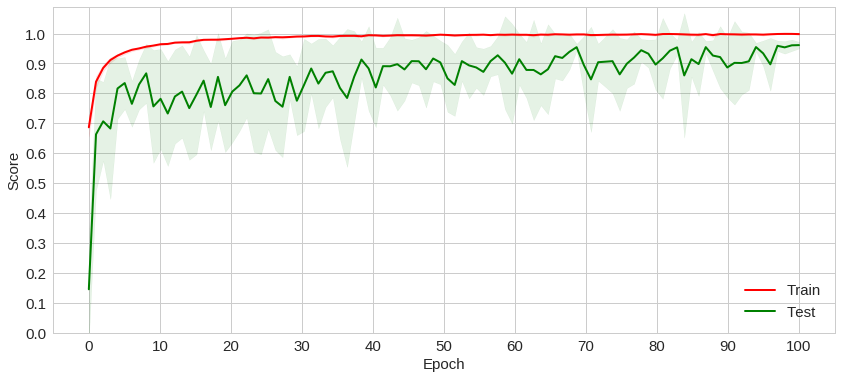

In [37]:
plot_mean_acc(hist)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

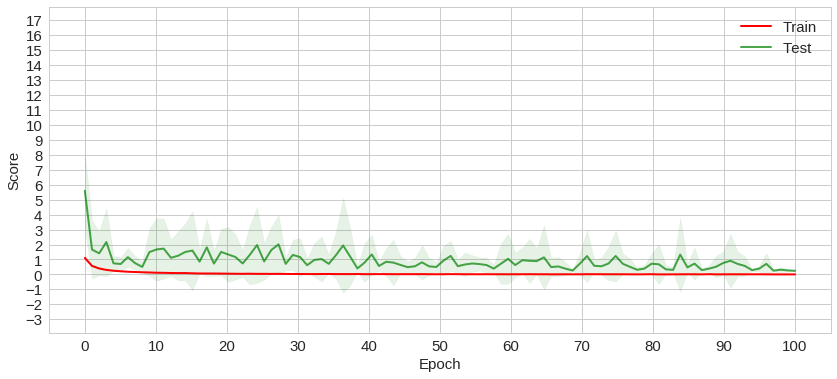

In [39]:
plot_mean_loss(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

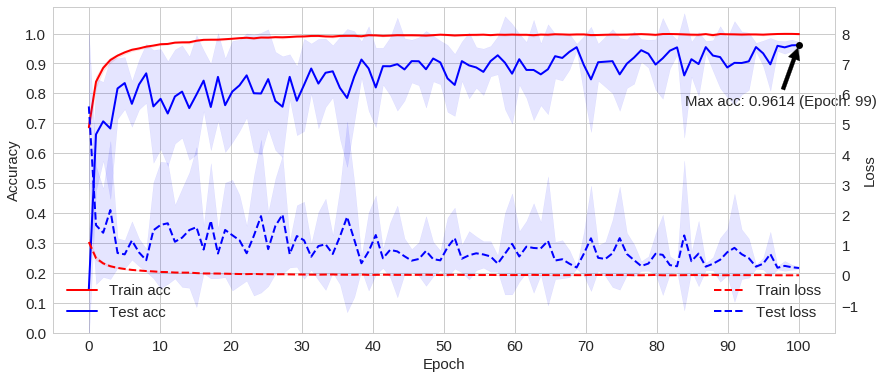

In [41]:
plot_mean(hist)